In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [11]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [12]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906'])

In [13]:
case_meta = pd.read_csv(os.path.join(output_dir, 'case_metadata.txt'), sep='\t')
case_meta = case_meta[[True if x not in exclude else False for x in case_meta['case']]]
case_meta['n_sections'] = [len(case_to_sections[x]) for x in case_meta['case']]
case_to_disease = {k:v for k, v in zip(case_meta['case'], case_meta['tissue_type'])}
    
case_meta

case tissue_type   cohort  n_sections
1          C3L-00982       CCRCC  inhouse           5
2          C3L-01287       CCRCC  inhouse           2
3          C3L-02551       CCRCC  inhouse           5
4            HT206B1        BRCA  inhouse          15
5            HT225C1         CRC  inhouse           4
6            HT268B1        BRCA  inhouse           4
7         HT339B2-H1        BRCA  inhouse           2
8            HT397B1        BRCA  inhouse          12
9         HT413C1-K2         CRC  inhouse           2
10   HT413C1-Th1k4A1         CRC  inhouse          28
11  HT448C1-Th1K1Fp1         CRC  inhouse           4
12        HT553P1-H2        PDAC  inhouse           2
13        HT565B1-H2        BRCA  inhouse           2
14       S18-5591-C8         PKD  inhouse          14
15          S18-9906         PKD  inhouse          13

In [14]:
case_order = case_meta.sort_values(['tissue_type', 'n_sections'])['case'].to_list()
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

HT339B2-H1


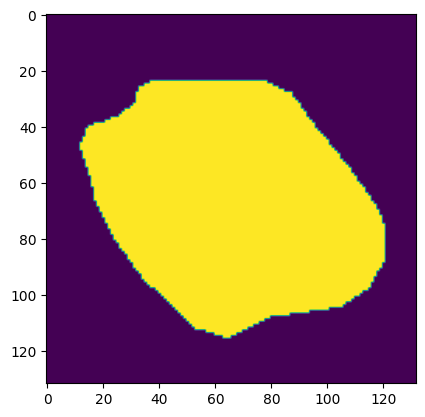

(132, 132) (2, 132, 132)
[(4, 19622, 3880), (3, 280, 0), (2, 234, 3084), (14, 126, 1402), (0, 120, 1956), (5, 86, 0), (13, 52, 672), (1, 50, 764), (11, 38, 1268), (7, 8, 294), (12, 6, 248), (8, 4, 66), (6, 4, 260), (16, 4, 98), (9, 4, 42), (18, 2, 20)]
HT565B1-H2


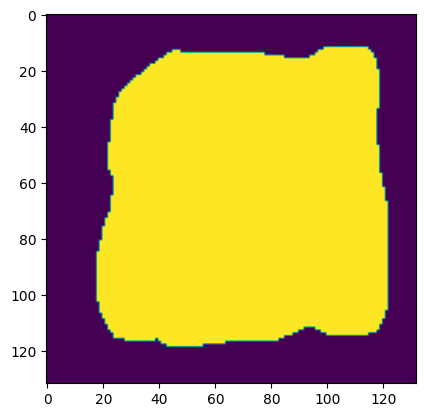

(132, 132) (3, 132, 132)
[(0, 19692, 7200), (4, 2211, 6651), (1, 579, 0)]
HT268B1


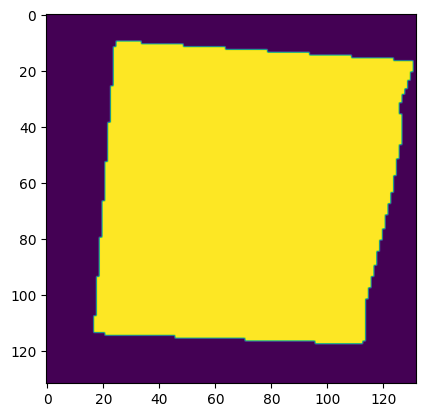

(132, 132) (32, 132, 132)
[(9, 98824, 16573), (5, 55456, 60409), (10, 51360, 1720), (0, 6999, 11083), (8, 5920, 25745), (3, 2085, 20405), (2, 715, 81215), (6, 603, 31021), (1, 333, 9471), (4, 331, 68278), (13, 125, 1506), (11, 48, 6233), (7, 17, 1028)]
HT397B1


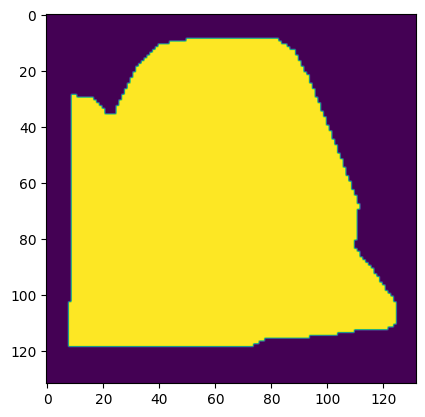

(132, 132) (31, 132, 132)
[(0, 220209, 108689), (15, 2881, 40690), (16, 1569, 17481), (12, 242, 10310), (11, 192, 11198), (1, 183, 8891), (2, 146, 5359), (3, 137, 22110), (8, 121, 943), (7, 105, 13162), (6, 101, 11422), (13, 39, 8304), (10, 34, 8040)]
HT206B1


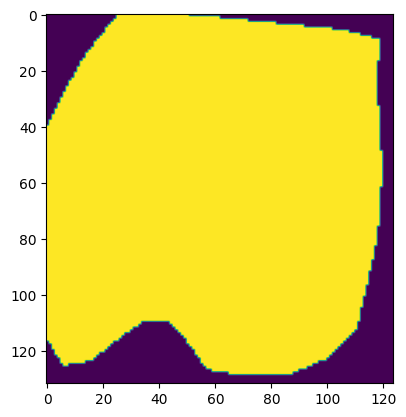

(132, 124) (25, 132, 124)
[(13, 57803, 108014), (15, 13375, 10017), (10, 22, 101822)]
C3L-01287


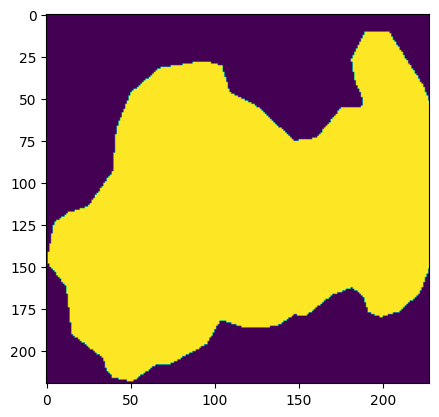

(220, 228) (2, 220, 228)
[(4, 41016, 19318), (10, 4, 2614), (14, 2, 3694)]
C3L-00982


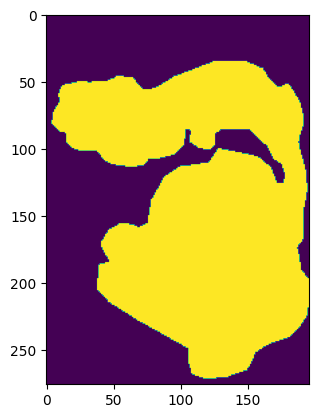

(276, 196) (7, 276, 196)
[(0, 168329, 64531), (33, 8183, 18473), (3, 819, 28650), (32, 511, 9912)]
C3L-02551


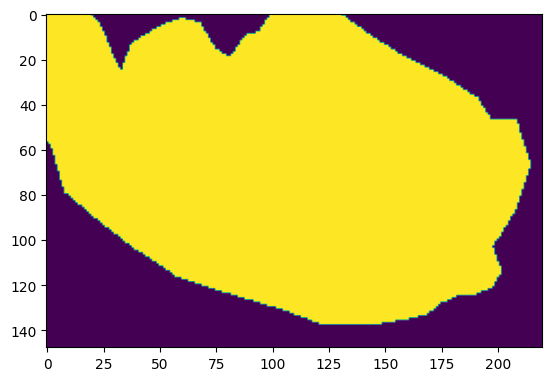

(148, 220) (8, 148, 220)
[(3, 83140, 33730), (10, 4, 176)]
HT413C1-K2


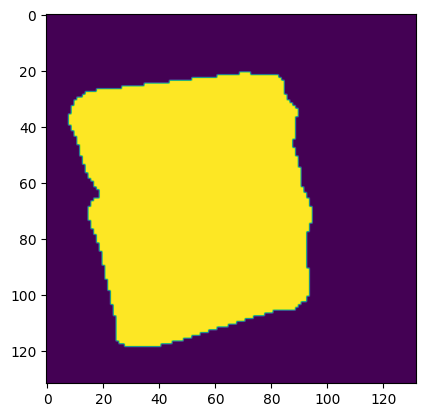

(132, 132) (2, 132, 132)
[(5, 21442, 2196), (12, 82, 0), (13, 44, 0)]
HT225C1


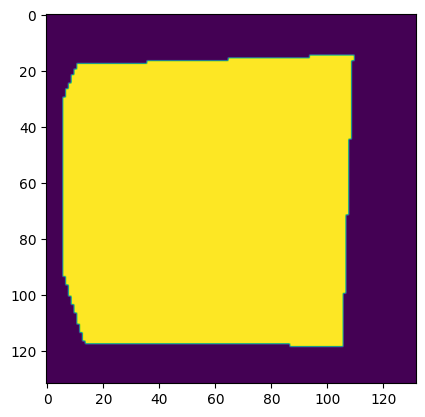

(132, 132) (37, 132, 132)
[(0, 217623, 52301), (4, 38877, 6568), (8, 3041, 42193), (3, 2374, 66155), (6, 1417, 43218), (7, 973, 36309), (2, 933, 9001), (9, 850, 28477), (1, 661, 30799), (5, 521, 24091), (12, 200, 12216), (13, 180, 7219), (11, 167, 13685), (10, 94, 3763), (14, 6, 776)]
HT448C1-Th1K1Fp1


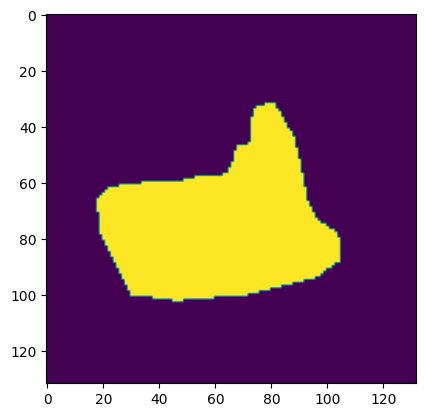

(132, 132) (14, 132, 132)
[(11, 181131, 10861), (4, 5284, 1282), (9, 3910, 13348), (1, 1352, 4106), (8, 486, 4448), (3, 481, 2282), (5, 443, 4649), (0, 247, 5970), (10, 210, 565), (12, 102, 256), (13, 52, 559), (7, 28, 1687), (2, 20, 125)]
HT413C1-Th1k4A1


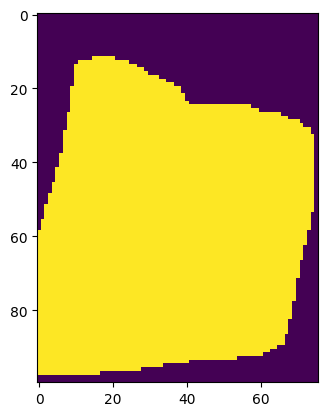

(100, 76) (42, 100, 76)
[(0, 90256, 63296), (16, 12516, 4286), (9, 2, 36142)]
HT553P1-H2


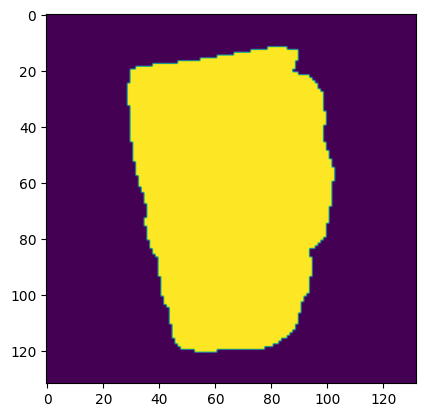

(132, 132) (2, 132, 132)
[(0, 22150, 2366), (1, 28, 0), (26, 2, 666)]
S18-9906


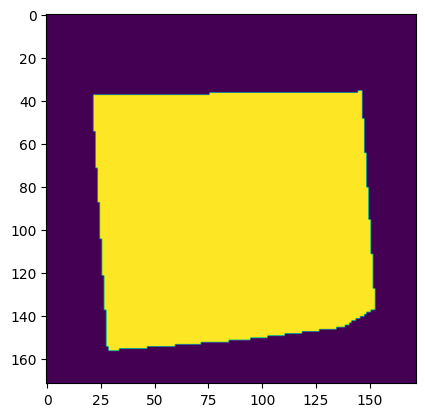

(172, 172) (33, 172, 172)
[(14, 204336, 9298), (7, 200739, 77023), (10, 40386, 52907), (3, 16908, 91570), (2, 11537, 58320), (1, 8004, 34029), (5, 7800, 52302), (13, 5147, 21593), (0, 4806, 32213), (6, 3087, 20358), (4, 1944, 16065), (12, 995, 1779), (8, 374, 853), (9, 237, 324), (11, 67, 236), (17, 37, 178), (19, 36, 234), (15, 20, 121), (18, 12, 157), (20, 6, 110), (16, 6, 118)]
S18-5591-C8


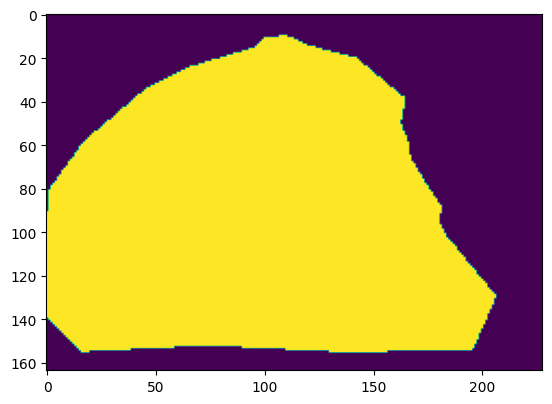

(164, 228) (24, 164, 228)
[(54, 325962, 81521), (31, 14754, 63980), (0, 9051, 121028), (30, 4948, 65577), (33, 593, 17453), (27, 550, 663), (9, 441, 76106), (26, 375, 1229), (11, 343, 561), (3, 218, 8052), (32, 180, 4), (1, 81, 22002), (25, 79, 2989), (34, 20, 31524), (4, 14, 14453), (7, 6, 2722), (10, 4, 118), (5, 3, 8502), (12, 2, 994)]


In [15]:
from collections import Counter
for case in case_order:
    print(case)
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb'))['labeled']['integrated']
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = v.shape[1:]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    plt.imshow(tissue_mask)
    plt.show()
    
    mask_counts = Counter(v[..., ~tissue_mask].flatten())
    other_counts = Counter(v[..., tissue_mask].flatten())
    
    print(tissue_mask.shape, v.shape)
    print([(c, val, other_counts[c]) for c, val in mask_counts.most_common()])
    
    


In [16]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
case_to_background = {
    'HT339B2-H1': [4, 3],
    'HT565B1-H2': [0],
    'HT268B1': [9],
    'HT397B1': [0],
    'HT206B1': [13],
    'C3L-01287': [4],
    'C3L-00982': [0],
    'C3L-02551': [3],
    'HT413C1-K2': [5],
    'HT225C1': [0],
    'HT448C1-Th1K1Fp1': [11],
    'HT413C1-Th1k4A1': [0, 16],
    'HT553P1-H2': [0],
    'S18-9906': [14],
    'S18-5591-C8': [54]
}

In [18]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/outputs.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/ou

In [19]:
# for case in case_order:
#     print(case)
#     config = yaml.safe_load(open(os.path.join(project_dir, case, 'mushroom_50res', 'config.yaml')))
#     config['trainer_kwargs']['pct_expression'] = None # make sure we get all visium genes
#     config['dtype_to_chkpt'] = None

#     mushroom = Mushroom.from_config(
#         config, accelerator='cpu'
#     )
#     mushroom.embed_sections()
    
    
    
#     to_true_pixels = {}
#     target_size = None
#     for dtype, spore in mushroom.dtype_to_spore.items():
#         target_size = spore.true_pixels[0].shape[:-1]
#         print(dtype, target_size, spore.true_pixels[0].shape)
#         to_true_pixels[dtype] = {
#             'channels': spore.learner_data.dtype_to_channels[dtype],
#             'true_pixels': spore.true_pixels
#         }
#     print(target_size)
    
#     pickle.dump(to_true_pixels,
#                 open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'wb'), protocol=4)
#     del(to_true_pixels)
    
    
#     to_true_pixels = {}
#     for dtype, spore in mushroom.dtype_to_spore.items():
#         sids = [x for x, _ in spore.section_ids]
#         to_img = spore.learner_data.dtype_to_section_to_img[dtype]
#         imgs = [to_img[sid] for sid in sids]
#         print(dtype, len(imgs), imgs[0].shape)
#         imgs = [utils.rescale(x, size=target_size, dim_order='c h w', target_dtype=x.dtype) for x in imgs]
#         print(dtype, len(imgs), imgs[0].shape)
#         imgs = [rearrange(x, 'c h w -> h w c').numpy() for x in imgs]
        
#         to_true_pixels[dtype] = {
#             'channels': spore.learner_data.dtype_to_channels[dtype],
#             'true_pixels': imgs
#         }
    
#     pickle.dump(to_true_pixels,
#                 open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'wb'), protocol=4)

In [20]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/true_pixels_raw.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/true_pixels_raw.pkl',


In [21]:
fps = sorted(utils.listfiles(project_dir, regex=r'cytospace_.*/outputs/cell_type_assignments_by_spot.csv$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section1/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section2/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section3/outputs/cell_type_assignments_by_spot.csv',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium

In [22]:
df = pd.read_csv(fps[0], sep=',', index_col=0)
df

T_reg  Pericyte   T  Tumor  Proximal_tubule  Macrophage  \
SpotID                                                               
h55_w102       4         0  15      0                0           0   
h164_w75       0        11   0      0                0           0   
h236_w165      0         0  38      0                0           0   
h180_w162      0         0   0     23                0           0   
h186_w174      0         0   0      1               10           0   
...          ...       ...  ..    ...              ...         ...   
h54_w17        0         1   0      0                0           0   
h79_w61        0         0   0      0                0           0   
h58_w147       0         1   0      0                0           0   
h153_w162      0         0   0      0                1           0   
h148_w189      1         0   0      0                0           0   

           Endothelial  Doublet  Fibroblast  Loop_of_Henle  B  pDC  NK  Mast  \
SpotID                                                                         
h55_w102             1        2           4              0  0    0   0     0   
h164_w75            19        0           0              0  0    0   0     0   
h236_w165            0        0           0              0  0    0   4     0   
h180_w162            0        0           0              0  0    0   0     0   
h186_w174            0        0           4              6  0    0   0     0   
...                ...      ...         ...            ... ..  ...  ..   ...   
h54_w17              0        0           0              0  0    0   0     0   
h79_w61              0        0           4              0  0    0   0     0   
h58_w147             0        0           0              0  0    0   0     0   
h153_w162            0        0           0              0  0    0   0     0   
h148_w189            0        0           0              0  0    0   0     0   

           Total cells  
SpotID                  
h55_w102            26  
h164_w75            30  
h236_w165           42  
h180_w162           23  
h186_w174           21  
...                ...  
h54_w17              1  
h79_w61              4  
h58_w147             1  
h153_w162            1  
h148_w189            1  

[22433 rows x 15 columns]

In [29]:
cell_type_mapping = {
    'LumHR': 'Epithelial',
    'Tumor': 'Epithelial',
    'LumSec': 'Epithelial',
    'Basal': 'Epithelial',
    'Ductal': 'Epithelial',
    'Basal_Epithelium': 'Epithelial',
    'Luminal_Epithelium': 'Epithelial',
    'Luminal_Tumor': 'Epithelial',
    'Myeloid': 'Macrophage',
    'Smooth_Muscle_Cells_Fibroblast_Mix': 'Fibroblast',
    'T_NK': 'T_cell',
    'T': 'T_cell',
    'B': 'B_cell',
    'Islet_alpha': 'Islet',
    'Islet_beta': 'Islet',
    'Islet_delta': 'Islet',
    'Islet_gamma': 'Islet',
}
excluded_cell_types = [
    'Doublet',
    'Remove_Unknown',
    'Plasma',
    'Schwann',
#     'Club_Cells',
#     'Hillock_Cells'
]

In [30]:
# case = 'HT206B1'
case_to_cytospace = {}
for case in case_order:
    outputs = pickle.load(open(os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    sids = outputs['section_ids']
    size = next(iter(outputs['dtype_to_clusters'].values()))[0].shape[1:]

    sid_to_cytospace = {}
    dtype_to_count = {dt:0 for dt in set([x for _, x in sids])}
    channels = []
    for sid, dtype in sids:
        if dtype in ['visium', 'xenium']:
            count = dtype_to_count[dtype]
            fp = os.path.join(project_dir, case, f'cytospace_{dtype}_section{count}', 'outputs', 'cell_type_assignments_by_spot.csv')
            df = pd.read_csv(fp, sep=',', index_col=0)
            df = df.iloc[:, :-1] # dont need total cells
            
            df = df[[c for c in df.columns if c not in excluded_cell_types]]
            renamed = [cell_type_mapping.get(c, c) for c in df.columns]
            count_dict = {}
            for ct in sorted(set(renamed)):
                idxs = [i for i, x in enumerate(renamed) if x == ct]
                count_dict[ct] = df.values[:, idxs].sum(1)
            merged = pd.DataFrame.from_dict(count_dict)
            merged.index = df.index.to_list()
            merged.columns = sorted(set(renamed))

            tiled = np.zeros((size[0], size[1], merged.shape[1]), dtype=int)
            for i, spotid in enumerate(merged.index.to_list()):
                h = int(re.sub(r'^h([0-9]+).*$', r'\1', spotid))
                w = int(re.sub(r'^.*w([0-9]+)$', r'\1', spotid))
                tiled[h, w] = merged.values[i]

            sid_to_cytospace[(sid, dtype)] = tiled
            channels = list(merged.columns)

            dtype_to_count[dtype] += 1
    case_to_cytospace[case] = {
        'sid_to_cytospace': sid_to_cytospace,
        'channels': channels
    }

In [31]:
for case, d in case_to_cytospace.items():
    sid_to_cytospace = d['sid_to_cytospace']
    channels = d['channels']
    print(case, channels)


HT339B2-H1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT565B1-H2 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT268B1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT397B1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
HT206B1 ['Adipocyte', 'B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Mast', 'Pericyte', 'T_cell', 'pDC']
C3L-01287 ['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Loop_of_Henle', 'Macrophage', 'Mast', 'NK', 'Pericyte', 'Proximal_tubule', 'T_cell', 'T_reg', 'pDC']
C3L-00982 ['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Loop_of_Henle', 'Macrophage', 'Mast', 'NK', 'Pericyte', 'Proximal_tubule', 'T_cell', 'T_reg', 'pDC']
C3L-02551 ['B_cell', 'Endothelia

In [32]:
def show_cytospace(case, show_channels=None):
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']

    if show_channels is None:
        show_channels = channels

    nrows, ncols = len(sid_to_cytospace), len(show_channels)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols, nrows))
    if nrows == 1:
        axs = rearrange(axs, 'c -> 1 c')
    if ncols == 1:
        axs = rearrange(axs, 'c -> c 1')

    for i, ((sid, dtype), tiled) in enumerate(sid_to_cytospace.items()):
        for j, channel in enumerate(show_channels):
            ax = axs[i, j]
            img = tiled[..., channels.index(channel)]
            ax.imshow(img)
            if i==0: ax.set_title(channel)
            if j==0: ax.set_ylabel(dtype)
            ax.set_xticks([])
            ax.set_yticks([])

HT339B2-H1


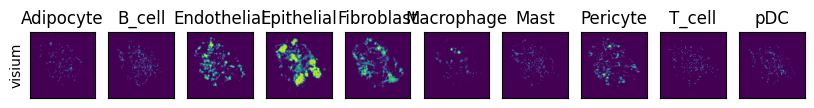

HT565B1-H2


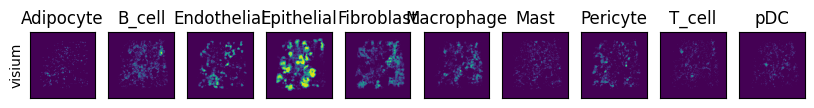

HT268B1


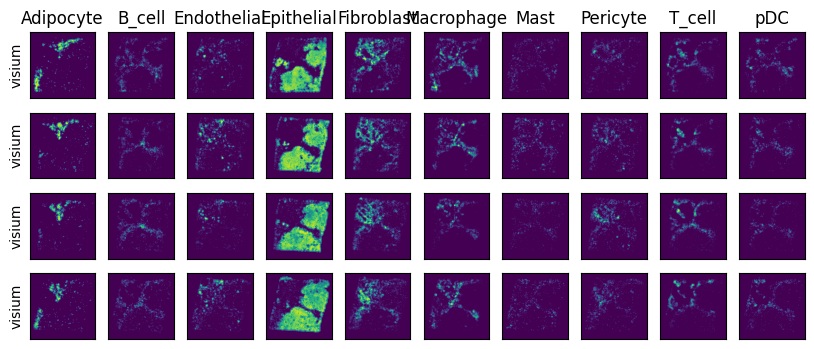

HT397B1


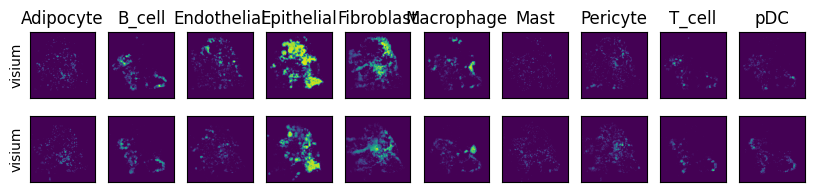

HT206B1


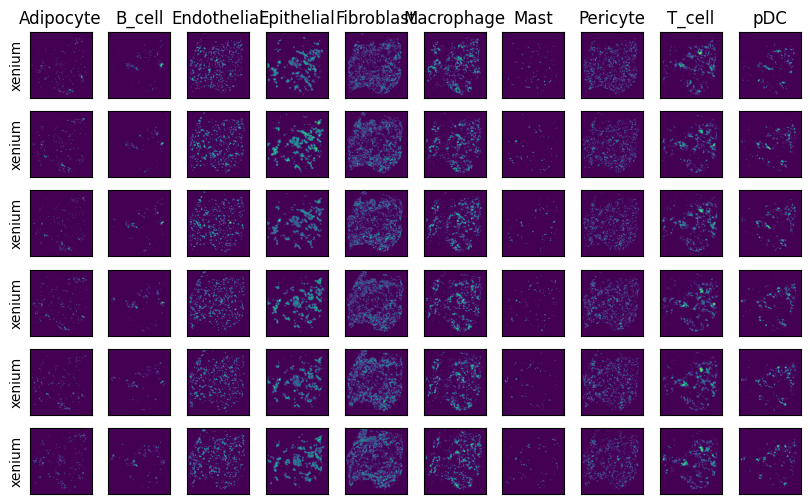

C3L-01287


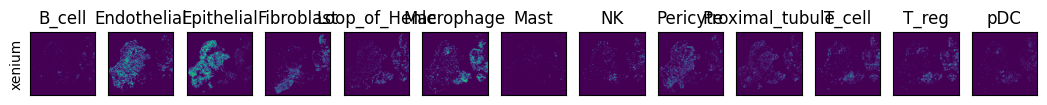

C3L-00982


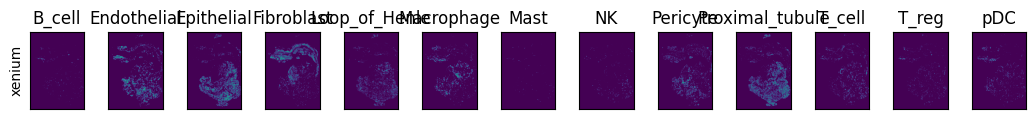

C3L-02551


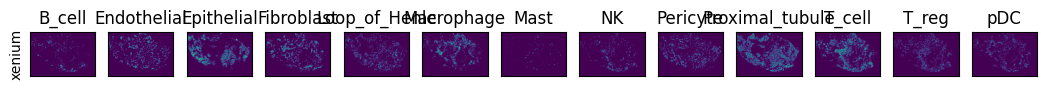

HT413C1-K2


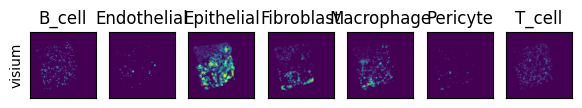

HT225C1


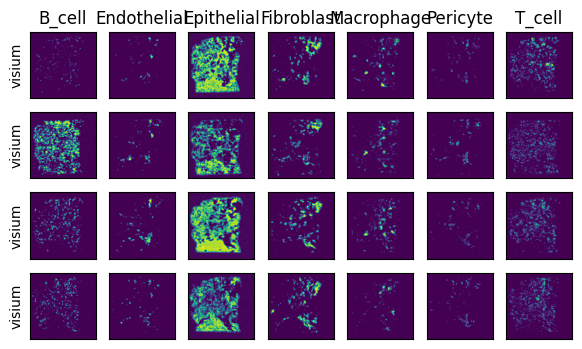

HT448C1-Th1K1Fp1


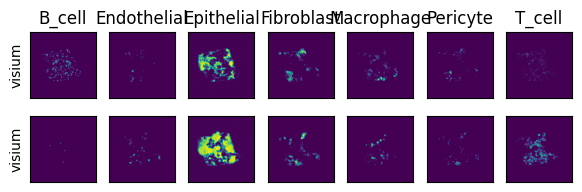

HT413C1-Th1k4A1


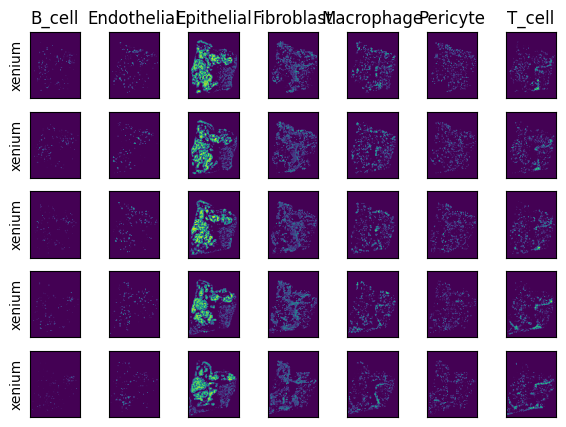

HT553P1-H2


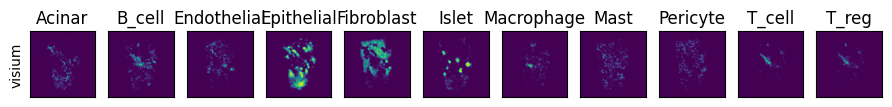

S18-9906


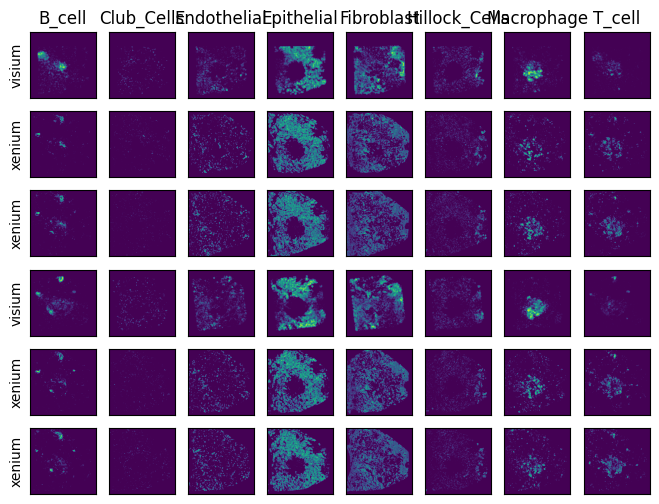

S18-5591-C8


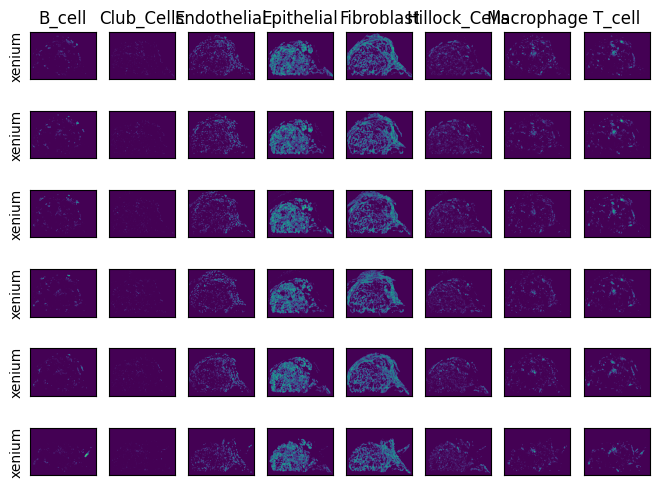

In [34]:
for case in case_order:
    print(case)
    show_cytospace(case)
    plt.show()

In [35]:
case_to_exp = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'rb')
    )
    
    dtypes = [dt for dt in dtype_to_true_pixels.keys() if dt != 'integrated']
    dtype_to_exp = {}
    for dtype in dtypes:    
        channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
        true_pixels = np.stack(true_pixels)
        
#         # norm by grid count for visium and xenium
#         if dtype in ['visium', 'xenium', 'cosmx']:
#             true_pixels = rearrange(true_pixels, 'n h w c -> n c h w')
#             true_pixels /= (true_pixels.sum((0, 1)) + 1)
#             true_pixels = rearrange(true_pixels, 'n c h w -> n h w c')

        volume = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
        )['labeled']['integrated']

        outputs = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
        )
        section_ids = outputs['section_ids']
        section_positions = outputs['section_positions']
        positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
        volume = volume[positions]
        
        print(volume.shape, true_pixels.shape)
        data = []
        for label in np.unique(volume):
            data.append(true_pixels[volume==label].mean(0))
        exp_df = pd.DataFrame(data=data, columns=channels, index=np.unique(volume))
        dtype_to_exp[dtype] = exp_df
    
    case_to_exp[case] = dtype_to_exp
    
    

HT339B2-H1
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT565B1-H2
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT268B1
(4, 132, 132) (4, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 36601)
HT397B1
(6, 132, 132) (6, 132, 132, 3)
(2, 132, 132) (2, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 24)
(2, 132, 132) (2, 132, 132, 17943)
HT206B1
(3, 132, 124) (3, 132, 124, 3)
(6, 132, 124) (6, 132, 124, 36)
(6, 132, 124) (6, 132, 124, 377)
C3L-01287
(1, 220, 228) (1, 220, 228, 29)
(1, 220, 228) (1, 220, 228, 477)
C3L-00982
(1, 276, 196) (1, 276, 196, 3)
(3, 276, 196) (3, 276, 196, 32)
(1, 276, 196) (1, 276, 196, 477)
C3L-02551
(1, 148, 220) (1, 148, 220, 3)
(3, 148, 220) (3, 148, 220, 32)
(1, 148, 220) (1, 148, 220, 477)
HT413C1-K2
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT225C1
(4, 132, 132) (4, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 3660

In [36]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [37]:
# masking_dtype_order = [
#     'xenium',
#     'visium',
# ]

HT339B2-H1
26


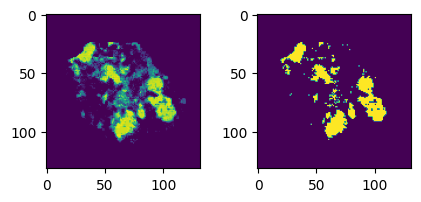

HT565B1-H2
31


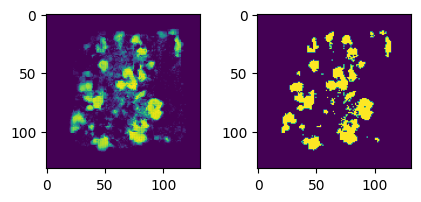

HT268B1
26
25
26
26


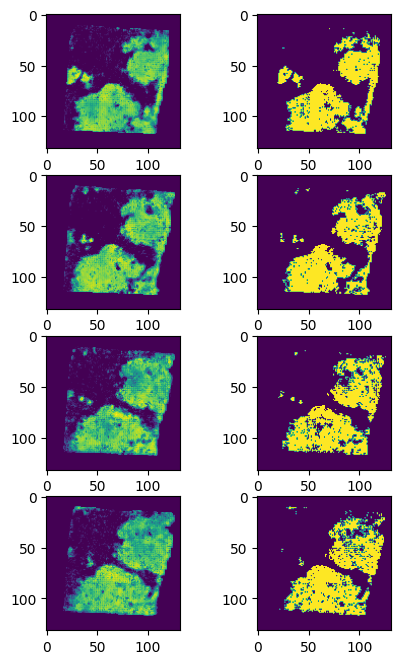

HT397B1
29
40


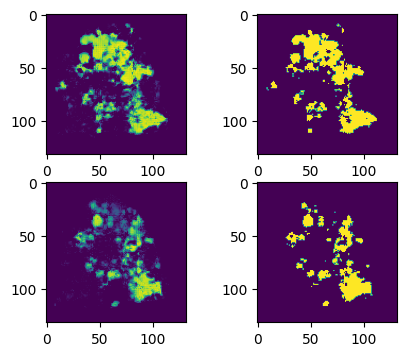

HT206B1
52
44
59
50
55
52


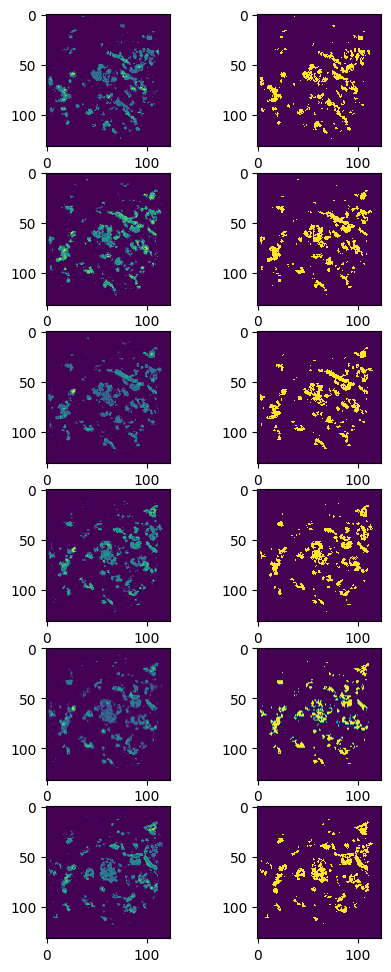

C3L-01287
25


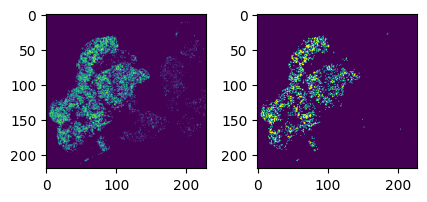

C3L-00982
30


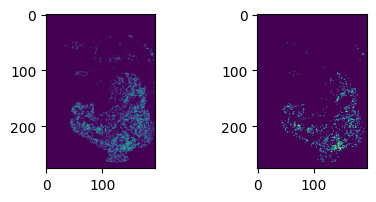

C3L-02551
23


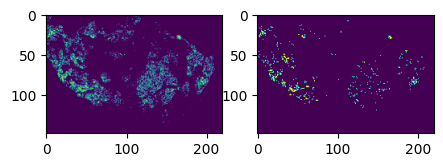

HT413C1-K2
32


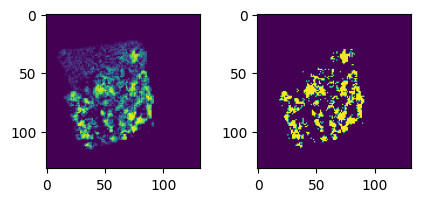

HT225C1
40
39
40
42


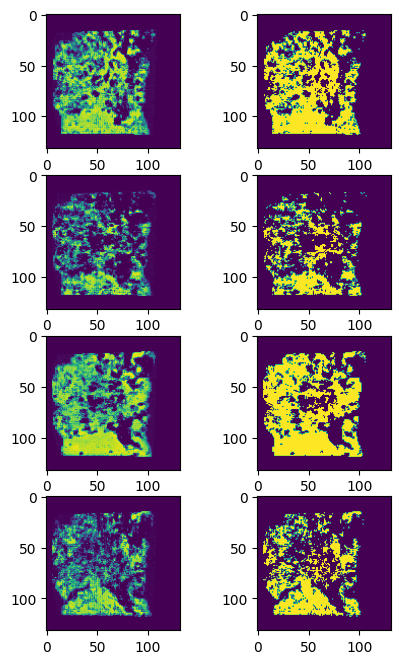

HT448C1-Th1K1Fp1
99
97


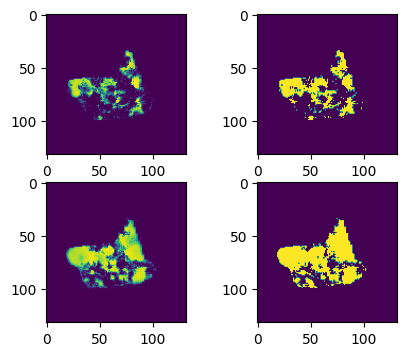

HT413C1-Th1k4A1
33
34
34
37
39


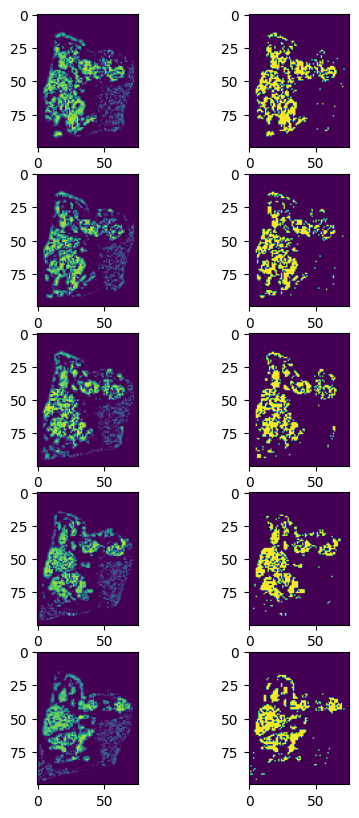

HT553P1-H2
31


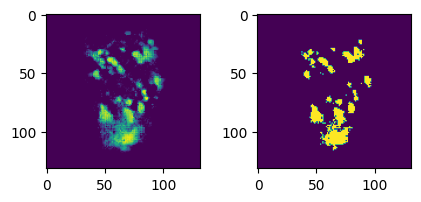

S18-9906
38
32
33
35
32
32


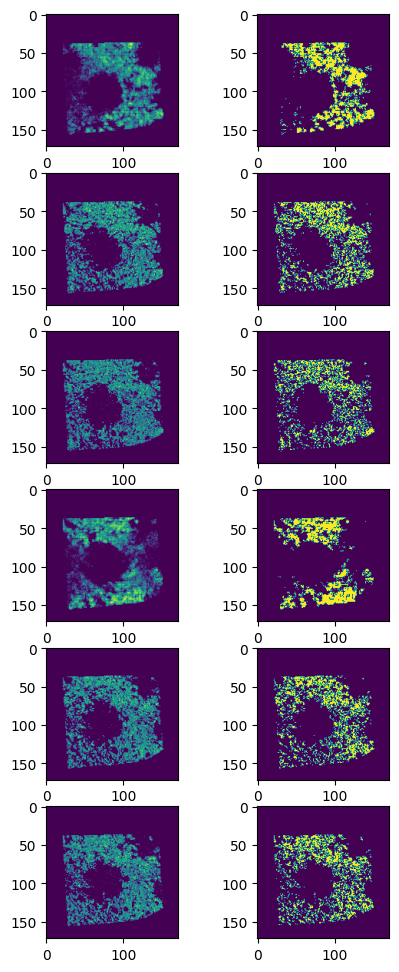

S18-5591-C8
36
36
35
39
35
35


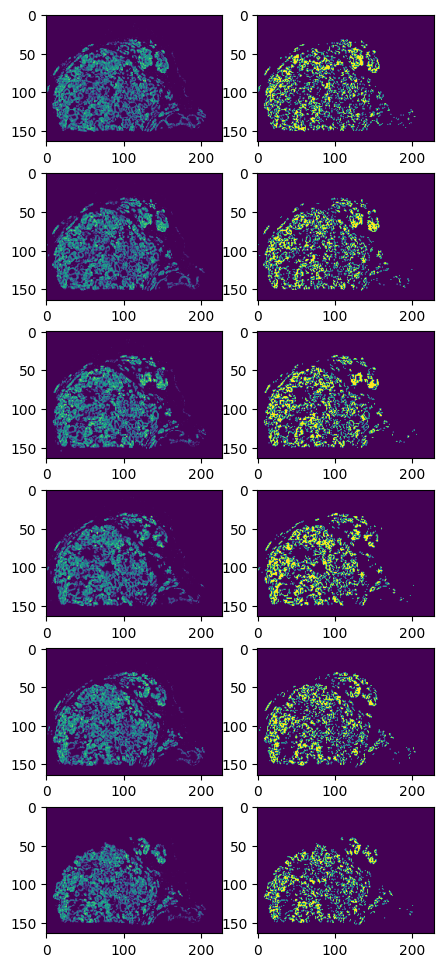

In [38]:
case_to_tumor_mask = {}
for case in case_order:
    print(case)

    section_ids = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb')
    )['section_ids']
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']
    section_ids = [x for x in section_ids if x in sid_to_cytospace]    
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = next(iter(sid_to_cytospace.values())).shape[:2]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    
    thresh = 15
    
    nrows = len(section_ids)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(5, nrows * 2))
    if nrows == 1:
        axs = rearrange(axs, 'n -> 1 n')
    
    masks = []
    for i, section_id in enumerate(section_ids):
        tiled = sid_to_cytospace[section_id]
        img = tiled[..., channels.index('Epithelial')]
        img[~tissue_mask] = img.min()
#         fracs = tiled / tiled.sum((0, 1))
#         img = fracs[..., channels.index('Epithelial')]
#         img[~tissue_mask] = img.min()
#         img = skimage.filters.gaussian(img)
        print(img.max())
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(img > thresh)
        masks.append(img > thresh)
    plt.show()
    
    tumor_mask = np.stack(masks)
    
    case_to_tumor_mask[case] = tumor_mask


    

In [39]:
outputs = pickle.load(
    open(os.path.join(project_dir, 'HT397B1', 'mushroom_50res', f'outputs.pkl'), 'rb')
)
outputs.keys()


dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [40]:
# case_to_true_slice = {}
case_to_labeled_slice = {}
for case in case_order:
    print(case)
#     dtype_to_true_pixels = pickle.load(
#         open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
#     )
    
#     dtype = [dt for dt in masking_dtype_order if dt in dtype_to_true_pixels][0]
#     channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
#     true_pixels = true_pixels[0]
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    labeled = volume[0]
    
#     case_to_true_slice[case] = true_pixels
    case_to_labeled_slice[case] = labeled

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [41]:
def get_nbhd_rgb(case, nbhds):
    labeled = case_to_labeled_slice[case]
    rgb = vis_utils.display_labeled_as_rgb(labeled)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb

def get_intensity_img(case, dtype, gene):
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    img = true_pixels[..., channels.index(gene)]
    
    return img


In [123]:
case_to_contact_counts = {}
case_to_tumor_counts = {}
case_to_overall_counts = {}
for case in case_order:
    print(case)
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    
    outputs = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
    )
    section_ids = outputs['section_ids']
    section_positions = outputs['section_positions']
#     dtypes = sorted(set([v for _, v in section_ids]))
    
#     dtype = [dt for dt in masking_dtype_order if dt in dtypes][0]

    positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if (sid, dt) in sid_to_cytospace]
    volume = volume[positions]
    
    tumor_mask = case_to_tumor_mask[case]
    
    assert volume.shape[0] == tumor_mask.shape[0]
    
    data, labels = [], np.unique(volume)
    counts = Counter()
    tumor_counts = Counter()
    overall_counts = Counter()
    for v, m in zip(volume, tumor_mask):
        expanded = skimage.morphology.binary_dilation(m)
        boundary = expanded ^ m
        counts += Counter(v[boundary])
        tumor_counts += Counter(v[m])
        overall_counts += Counter(v.flatten())
    
    case_to_contact_counts[case] = counts
    case_to_tumor_counts[case] = tumor_counts
    case_to_overall_counts[case] = overall_counts

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [124]:
case_to_contact_counts['HT397B1'], case_to_tumor_counts['HT397B1']

(Counter({4: 269,
          3: 260,
          14: 216,
          5: 139,
          7: 128,
          15: 126,
          12: 107,
          0: 102,
          10: 102,
          1: 65,
          6: 47,
          16: 43,
          11: 42,
          13: 40,
          9: 31,
          2: 29,
          19: 2,
          8: 2,
          18: 1}),
 Counter({4: 1187,
          1: 455,
          3: 349,
          10: 345,
          2: 333,
          5: 284,
          14: 256,
          12: 143,
          15: 109,
          0: 100,
          7: 90,
          9: 68,
          16: 41,
          13: 33,
          6: 18,
          11: 14,
          8: 2}))

In [125]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

dict_keys(['GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2', 'GAVISH_3CA_MALIGNANT_ME

In [126]:
# dtype_to_gene_order = {dtype: set() for dtype in dtype_to_integrated.keys()}
# for dtype, df in dtype_to_integrated.items():
#     dtype_to_gene_order[dtype].update(df.columns)
# dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_gene_order = {}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype not in dtype_to_gene_order:
            dtype_to_gene_order[dtype] = set()
    dtype_to_gene_order[dtype].update(df.columns)
dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_exp_df = {dt:None for dt in dtype_to_gene_order}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
#     dtype_to_integrated = case_to_integrated[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype in dtype_to_gene_order:
            order = dtype_to_gene_order[dtype]
            missing = sorted(set(order) - set(df.columns))
            tail = pd.DataFrame(data=np.full((df.shape[0], len(missing)), df.values.min()))
            tail.columns = missing
            tail.index = df.index
            combined = pd.concat((df, tail), axis=1)
            combined = combined[order]
            combined.index = [(case, nbhd) for nbhd in df.index.to_list()]

            if dtype_to_exp_df[dtype] is None:
                dtype_to_exp_df[dtype] = combined
            else:
                dtype_to_exp_df[dtype] = pd.concat((dtype_to_exp_df[dtype], combined), axis=0)

In [127]:
quant_dtypes = ['xenium', 'visium', 'cosmx']

data = []
exp_data = []
for case in case_order:
    print(case)
#     dtype_to_integrated = case_to_integrated[case]
    dtype_to_integrated = case_to_exp[case]
    dtypes = [qdt for qdt in quant_dtypes if qdt in dtype_to_integrated]
    for quant_dtype in dtypes:
        df = dtype_to_integrated[quant_dtype]
        for name, gs in gene_sets.items():
            genes = [g for g in gs['geneSymbols'] if g in df.columns]
            if len(genes) >= 3:
                nbhd_scores = df[genes].values.mean(1)
                for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                    data.append([case, quant_dtype, name, nbhd, score])

score_df = pd.DataFrame(data, columns=['case', 'dtype', 'gene_set', 'nbhd', 'score'])
score_df


HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


case   dtype                                           gene_set  \
0       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
1       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
2       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
3       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
4       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
...            ...     ...                                                ...   
49787  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49788  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49789  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49790  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49791  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   

       nbhd     score  
0         0  1.493730  
1         1  0.682513  
2         2  0.197669  
3         3  0.193870  
4         4  0.030979  
...     ...       ...  
49787    52  1.071059  
49788    53  1.434338  
49789    54  0.124539  
49790    55  1.630600  
49791    56  1.391970  

[49792 rows x 5 columns]

In [128]:
case_to_background

{'HT339B2-H1': [4, 3],
 'HT565B1-H2': [0],
 'HT268B1': [9],
 'HT397B1': [0],
 'HT206B1': [13],
 'C3L-01287': [4],
 'C3L-00982': [0],
 'C3L-02551': [3],
 'HT413C1-K2': [5],
 'HT225C1': [0],
 'HT448C1-Th1K1Fp1': [11],
 'HT413C1-Th1k4A1': [0, 16],
 'HT553P1-H2': [0],
 'S18-9906': [14],
 'S18-5591-C8': [54]}

In [129]:
df = score_df.copy()
df = df.pivot(columns='gene_set', index=['case', 'dtype', 'nbhd'])
df = df.reset_index()

df = df[[False if nbhd in case_to_background[case] else True for case, nbhd in zip(df['case'], df['nbhd'])]]

df.index = [(case, nbhd) for case, nbhd in zip(df['case'], df['nbhd'])]


df

case   dtype nbhd  \
gene_set                                 
(C3L-00982, 1)  C3L-00982  xenium    1   
(C3L-00982, 2)  C3L-00982  xenium    2   
(C3L-00982, 3)  C3L-00982  xenium    3   
(C3L-00982, 4)  C3L-00982  xenium    4   
(C3L-00982, 5)  C3L-00982  xenium    5   
...                   ...     ...  ...   
(S18-9906, 16)   S18-9906  xenium   16   
(S18-9906, 17)   S18-9906  xenium   17   
(S18-9906, 18)   S18-9906  xenium   18   
(S18-9906, 19)   S18-9906  xenium   19   
(S18-9906, 20)   S18-9906  xenium   20   

                                                                score  \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION   
(C3L-00982, 1)                                           3.296440       
(C3L-00982, 2)                                           3.951151       
(C3L-00982, 3)                                           0.404217       
(C3L-00982, 4)                                           0.435817       
(C3L-00982, 5)                                           5.737449       
...                                                           ...       
(S18-9906, 16)                                                NaN       
(S18-9906, 17)                                                NaN       
(S18-9906, 18)                                                NaN       
(S18-9906, 19)                                                NaN       
(S18-9906, 20)                                                NaN       

                                                                           \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION   
(C3L-00982, 1)                                                NaN           
(C3L-00982, 2)                                                NaN           
(C3L-00982, 3)                                                NaN           
(C3L-00982, 4)                                                NaN           
(C3L-00982, 5)                                                NaN           
...                                                           ...           
(S18-9906, 16)                                                NaN           
(S18-9906, 17)                                                NaN           
(S18-9906, 18)                                                NaN           
(S18-9906, 19)                                                NaN           
(S18-9906, 20)                                                NaN           

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1   
(C3L-00982, 1)                                 15.099572   
(C3L-00982, 2)                                  5.810843   
(C3L-00982, 3)                                  2.339755   
(C3L-00982, 4)                                  8.788456   
(C3L-00982, 5)                                  9.765514   
...                                                  ...   
(S18-9906, 16)                                  6.000271   
(S18-9906, 17)                                  5.589149   
(S18-9906, 18)                                  5.502994   
(S18-9906, 19)                                  6.690787   
(S18-9906, 20)                                  6.941039   

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2   
(C3L-00982, 1)                                  8.233236   
(C3L-00982, 2)                                  3.899374   
(C3L-00982, 3)                                  1.085053   
(C3L-00982, 4)                                  3.773378   
(C3L-00982, 5)                                  6.320941   
...                                                  ...   
(S18-9906, 16)                                  1.341584   
(S18-9906, 17)                                  1.661936   
(S18-9906, 18)                                  1.493572   
(S18-9906, 19)                                  1.520338   
(S18-9906, 20)       

In [130]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [131]:
def score_gene_set(df, gene_set):
    data = []
    order = sorted(gene_set.keys())
    for name in order:
        genes = gene_set[name]
        f = df[[c for c in df.columns if c in genes]]
        data.append(f.values.mean(1).flatten())
    scored = pd.DataFrame(data=data, columns=df.index, index=order).T
    return scored

In [132]:
tiled = case_to_cytospace['HT397B1']['sid_to_cytospace'][('HT397B1-U1', 'visium')]
tiled.shape

(132, 132, 10)

In [133]:
# sums = tiled.sum(-1)
# sums[sums==0] += 1
# tiled /= np.expand_dims(sums, -1)
# tiled

In [134]:
# scoring_order = ['xenium', 'visium']
# case_to_scored = {}
# for case in case_order:
# #     dtype_to_integrated = case_to_integrated[case]
#     dtype_to_integrated = case_to_exp[case]
#     dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
    
#     scored = score_gene_set(dtype_to_integrated[dtype], components)
    
#     scored = scored[[True if x not in case_to_background[case] else False for x in scored.index]]
# #     scored -= np.expand_dims(scored.min(1), -1)
# #     scored /= np.expand_dims(scored.max(1), -1)
# #     scored -= scored.min(1)
# #     scored /= scored.max(1)
    
    
#     case_to_scored[case] = scored
# case_to_scored.keys()

In [137]:
tumor_thresh = .5
contact_thresh = .02

case_to_included = {}
for case in case_order:
    case_to_included[case] = []
    tumor_counts = case_to_tumor_counts[case]
    overall_counts = case_to_overall_counts[case]
    contact_counts = case_to_contact_counts[case]
    
    for nbhd, oc in overall_counts.items():
        tc = tumor_counts[nbhd]
        cc = contact_counts[nbhd]
        
        contact_frac = cc / sum(contact_counts.values())
        tumor_frac = tc / oc
        print(case, nbhd, tumor_frac, contact_frac)
        
        if tumor_frac < tumor_thresh and contact_frac > contact_thresh:
            case_to_included[case].append(nbhd)
case_to_included
        
        
        
    

HT339B2-H1 4 0.01063739256233512 0.20208604954367665
HT339B2-H1 14 0.0549738219895288 0.10299869621903521
HT339B2-H1 2 0.0325497287522604 0.12385919165580182
HT339B2-H1 8 0.11428571428571428 0.001303780964797914
HT339B2-H1 1 0.3759213759213759 0.09256844850065189
HT339B2-H1 6 0.18181818181818182 0.03259452411994785
HT339B2-H1 13 0.3011049723756906 0.0938722294654498
HT339B2-H1 0 0.6868978805394991 0.14341590612777053
HT339B2-H1 11 0.16079632465543645 0.1421121251629726
HT339B2-H1 7 0.19205298013245034 0.027379400260756193
HT339B2-H1 3 0.0 0.0
HT339B2-H1 5 0.0 0.0
HT339B2-H1 12 0.12598425196850394 0.02346805736636245
HT339B2-H1 18 0.09090909090909091 0.002607561929595828
HT339B2-H1 16 0.0 0.001303780964797914
HT339B2-H1 17 0.07407407407407407 0.007822685788787484
HT339B2-H1 15 0.058823529411764705 0.001303780964797914
HT339B2-H1 10 0.5 0.001303780964797914
HT339B2-H1 9 0.21739130434782608 0.0
HT565B1-H2 0 0.015171798304328426 0.1605911330049261
HT565B1-H2 4 0.022004062288422478 0.113300

{'HT339B2-H1': [4, 14, 2, 1, 6, 13, 11, 7, 12],
 'HT565B1-H2': [0, 4, 6, 2, 10, 5],
 'HT268B1': [9, 8, 5],
 'HT397B1': [0, 16, 12, 3, 14, 15, 7, 13, 11, 5, 6],
 'HT206B1': [15, 13, 10, 16, 1, 11, 8, 14, 6, 9],
 'C3L-01287': [4, 7, 9, 15, 11, 18, 13, 17],
 'C3L-00982': [33, 0, 32, 2, 5, 6],
 'C3L-02551': [3, 7, 4, 11, 13, 8, 0, 12],
 'HT413C1-K2': [5, 8, 0, 1, 6, 2],
 'HT225C1': [0, 4, 2, 5, 1, 3],
 'HT448C1-Th1K1Fp1': [11, 9, 8, 4],
 'HT413C1-Th1k4A1': [0, 9, 12, 4, 10, 6, 1, 5, 8, 11],
 'HT553P1-H2': [0, 26, 2, 4, 12, 9, 3, 18, 7, 5, 19, 6],
 'S18-9906': [7, 10, 0, 13, 3, 5, 2, 4, 1],
 'S18-5591-C8': [54, 31, 30, 0, 33, 9, 1, 34, 3, 5]}

In [236]:
case_to_scored = {}
for case in case_order:
    sid_to_cytospace = case_to_cytospace[case]['sid_to_cytospace']
    channels = case_to_cytospace[case]['channels']
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    
    outputs = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
    )
    section_ids = outputs['section_ids']
    section_positions = outputs['section_positions']

    
    positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if (sid, dt) in sid_to_cytospace]
    ids = [(sid, dt) for i, (sid, dt) in zip(section_positions, section_ids) if (sid, dt) in sid_to_cytospace]
    volume = volume[positions]
    
    labels = np.unique(volume)
    
    counts = []
    for section_id, labeled in zip(ids, volume):
        tiled = sid_to_cytospace[section_id].astype(float)
        
#         scaler = tiled.std()
#         tiled /= scaler
        
#         sums = tiled.std((0, 1))
#         tiled /= sums
        
#         sums = tiled.sum(-1)
#         sums[sums==0] += 1
#         tiled /= np.expand_dims(sums, -1)

        data = []
        for label in labels:
            m = labeled==label
            n = np.count_nonzero(m)
            if n == 0:
                x = np.asarray([0] * len(channels))
            else:
                x = tiled[m].mean(0)
            data.append(x)
        data = np.stack(data)
        counts.append(data)
    counts = np.stack(counts).mean(0)
    score_df = pd.DataFrame(counts, columns=channels, index=labels)
    
    score_df = score_df.loc[case_to_included[case]]
    
    case_to_scored[case] = score_df

In [237]:
cols = sorted(set([c for case, scored in case_to_scored.items() for c in scored.columns]))
cols

['Acinar',
 'Adipocyte',
 'B_cell',
 'Club_Cells',
 'Endothelial',
 'Epithelial',
 'Fibroblast',
 'Hillock_Cells',
 'Islet',
 'Loop_of_Henle',
 'Macrophage',
 'Mast',
 'NK',
 'Pericyte',
 'Proximal_tubule',
 'T_cell',
 'T_reg',
 'pDC']

In [238]:
common = sorted(set.intersection(*[set(scored.columns) for case, scored in case_to_scored.items()]))
common

['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'T_cell']

In [365]:
common = [
#     'Epithelial',
    'Fibroblast',
    'Endothelial',
    'Macrophage',
    'T_cell',
    'B_cell',
]

In [366]:
cases = []
dtypes = []
combined = None
for case, scored in case_to_scored.items():
    cases += [case] * len(scored)

#     dtype_to_integrated = case_to_exp[case]
#     dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
#     dtypes += [dtype] * len(scored)
    f = scored[common]

    if combined is None:
        combined = f.copy()
    else:
        combined = pd.concat((combined, f), axis=0)

combined

Fibroblast  Endothelial  Macrophage    T_cell    B_cell
4     0.173177     0.176751    0.008765  0.003149  0.023062
14    3.730366     3.760471    0.409686  0.030105  0.232984
2     7.173599     3.231465    0.418927  0.023508  0.145268
1     2.491400     3.643735    0.511057  0.027027  0.307125
6     2.143939     4.757576    0.810606  0.075758  0.393939
..         ...          ...         ...       ...       ...
9    11.449360     2.414063    0.906808  0.965007  0.471358
1     9.047613     5.086124    2.503533  3.022711  1.364066
34    4.512774     1.981696    1.089184  1.134916  0.410390
3     3.841850     3.836639    6.769121  7.977343  2.341862
5     7.279239     3.738567    1.662142  1.413911  0.552011

[118 rows x 5 columns]

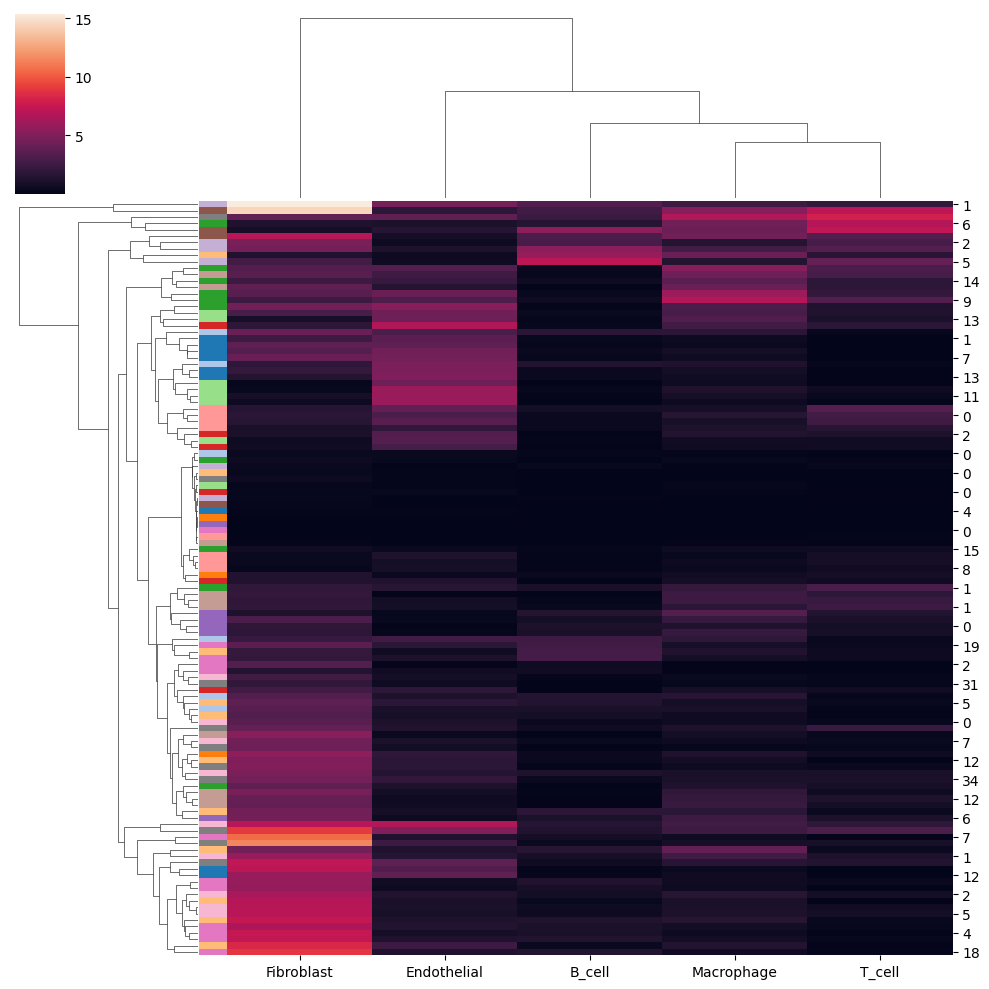

In [367]:
colors = [sns.color_palette('tab20')[case_order.index(z)] for z in cases]
# colors = [sns.color_palette('tab20')[order.index(z)] for z in dtypes]
sns.clustermap(combined, col_cluster=True, row_cluster=True, row_colors=colors)
plt.show()

In [368]:
cuts = [.75, .9, .95]
to_cuts = {}
for c in combined.columns:
    to_cuts[c] = {}
    for cut in cuts:
        val = combined.sort_values(c)[c].to_list()[int(cut * combined.shape[0])]
        to_cuts[c][cut] = val
print(to_cuts)

{'Fibroblast': {0.75: 4.697350230417924, 0.9: 7.173598553345389, 0.95: 8.872881355932204}, 'Endothelial': {0.75: 3.036406806489909, 0.9: 4.516556291390729, 0.95: 5.2317140484672215}, 'Macrophage': {0.75: 2.114691933461072, 0.9: 3.911679559111583, 0.95: 4.422167487684729}, 'T_cell': {0.75: 1.4087494476358815, 0.9: 2.970949312051959, 0.95: 3.3888864136921093}, 'B_cell': {0.75: 1.1196911196911197, 0.9: 2.5243088655862724, 0.95: 3.0481937602627256}}


In [476]:
# contact_thres = .02

agg = []
for case in case_order:
    counts = case_to_contact_counts[case]
    scored = case_to_scored[case]

#     total = sum(counts.values())
#     fracs = {k:v / total for k, v in counts.items()}

#     nbhds, contact_fracs = zip(*sorted([(nbhd, frac) for nbhd, frac in fracs.items()
#                                if frac > contact_thres
#                                if nbhd in scored.index],
#                               key=lambda x:-x[1]))
    nbhds = scored.index.to_list()
    contact_fracs = [case_to_contact_counts[case][x] / sum(case_to_contact_counts[case].values()) for x in nbhds]
    nbhds, contact_fracs = zip(*sorted([(nbhd, frac)
                                        for nbhd, frac in zip(nbhds, contact_fracs)],
                                       key=lambda x: x[1], reverse=True))
    
    exp = scored.loc[list(nbhds), common].copy()

    expanded = exp.copy()
    for cut in cuts:
        vals = np.asarray([to_cuts[c][cut] for c in exp.columns])
        m = exp > vals
        m.columns = [f'{c}_q{cut}' for c in m]
        expanded = pd.concat((expanded, m), axis=1)
    expanded['case'] = case
    expanded['tissue_type'] = case_to_disease[case]
    expanded['contact_frac'] = contact_fracs
    expanded['nbhd'] = [f'nbhd {x}' for x in exp.index.to_list()]
    agg.append(expanded)
agg = pd.concat(agg, axis=0)
agg['range'] = [f'item{x}' for x in np.arange(agg.shape[0])]
agg
    

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
4     0.173177     0.176751    0.008765  0.003149  0.023062             False   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
1     9.047613     5.086124    2.503533  3.022711  1.364066              True   
5     7.279239     3.738567    1.662142  1.413911  0.552011              True   
3     3.841850     3.836639    6.769121  7.977343  2.341862             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
4               False             False         False         False  ...   
11               True             False         False         False  ...   
2                True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
54              False             False         False         False  ...   
33              False             False          True         False  ...   
1                True              True          True          True  ...   
5                True             False          True         False  ...   
3                True              True          True          True  ...   

    Fibroblast_q0.95  Endothelial_q0.95  Macrophage_q0.95  T_cell_q0.95  \
4              False              False             False         False   
11             False              False             False         False   
2              False              False             False         False   
14             False              False             False         False   
13             False              False             False         False   
..               ...                ...               ...           ...   
54             False              False             False         False   
33             False              False             False         False   
1               True              False             False         False   
5              False              False             False         False   
3              False              False              True          True   

    B_cell_q0.95         case  tissue_type  contact_frac     nbhd    range  
4          False   HT339B2-H1         BRCA      0.202086   nbhd 4    item0  
11         False   HT339B2-H1         BRCA      0.142112  nbhd 11    item1  
2          False   HT339B2-H1         BRCA      0.123859   nbhd 2    item2  
14         False   HT339B2-H1         BRCA      0.102999  nbhd 14    item3  
13         False   HT339B2-H1         BRCA      0.093872  nbhd 13    item4  
..           ...          ...          ...           ...      ...      ...  
54         False  S18-5591-C8          PKD      0.082077  nbhd 54  item113  
33         False  S18-5591-C8          PKD      0.039807  nbhd 33  item114  
1          False  S18-5591-C8          PKD      0.038789   nbhd 1  item115  
5          False  S18-5591-C8          PKD      0.025027   nbhd 5  item116  
3          False  S18-5591-C8          PKD      0.021743   nbhd 3  item117  

[118 rows x 25 columns]

In [477]:
nbhd_mapping = {}
r_nbhd_mapping = {}
current_idx = -1
current_case = agg['case'].to_list()[0]
current_pct = 0.

nbhds = []
starts, stops = [], []
for case, nbhd, frac in zip(agg['case'], agg['nbhd'], agg['contact_frac']):
    if case == current_case:
        current_idx += 1
    else:
        current_idx = 0
        current_case = case
        current_pct = 0.
    
    start = current_pct
    stop = start + frac
    current_pct = stop
    
    starts.append(start)
    stops.append(stop)
    
    nbhd_str = f'nbhd {current_idx}'
    nbhds.append(nbhd_str)
    
    if case not in nbhd_mapping:
        nbhd_mapping[case] = {}
    nbhd_mapping[case][nbhd] = nbhd_str
r_nbhd_mapping = {case:{v:k for k, v in mapping.items()} for case, mapping in nbhd_mapping.items()}
    
agg['renamed_nbhd'] = nbhds
agg['start'] = starts
agg['stop'] = stops
agg['nbhd_identifier'] = [f'{case}_{nbhd}' for case, nbhd in zip(agg['case'], agg['nbhd'])]
agg['case_idx']= [-case_order.index(case) for case in agg['case']]
agg

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
4     0.173177     0.176751    0.008765  0.003149  0.023062             False   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
1     9.047613     5.086124    2.503533  3.022711  1.364066              True   
5     7.279239     3.738567    1.662142  1.413911  0.552011              True   
3     3.841850     3.836639    6.769121  7.977343  2.341862             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
4               False             False         False         False  ...   
11               True             False         False         False  ...   
2                True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
54              False             False         False         False  ...   
33              False             False          True         False  ...   
1                True              True          True          True  ...   
5                True             False          True         False  ...   
3                True              True          True          True  ...   

           case  tissue_type  contact_frac     nbhd    range  renamed_nbhd  \
4    HT339B2-H1         BRCA      0.202086   nbhd 4    item0        nbhd 0   
11   HT339B2-H1         BRCA      0.142112  nbhd 11    item1        nbhd 1   
2    HT339B2-H1         BRCA      0.123859   nbhd 2    item2        nbhd 2   
14   HT339B2-H1         BRCA      0.102999  nbhd 14    item3        nbhd 3   
13   HT339B2-H1         BRCA      0.093872  nbhd 13    item4        nbhd 4   
..          ...          ...           ...      ...      ...           ...   
54  S18-5591-C8          PKD      0.082077  nbhd 54  item113        nbhd 5   
33  S18-5591-C8          PKD      0.039807  nbhd 33  item114        nbhd 6   
1   S18-5591-C8          PKD      0.038789   nbhd 1  item115        nbhd 7   
5   S18-5591-C8          PKD      0.025027   nbhd 5  item116        nbhd 8   
3   S18-5591-C8          PKD      0.021743   nbhd 3  item117        nbhd 9   

       start      stop      nbhd_identifier  case_idx  
4   0.000000  0.202086    HT339B2-H1_nbhd 4         0  
11  0.202086  0.344198   HT339B2-H1_nbhd 11         0  
2   0.344198  0.468057    HT339B2-H1_nbhd 2         0  
14  0.468057  0.571056   HT339B2-H1_nbhd 14         0  
13  0.571056  0.664928   HT339B2-H1_nbhd 13         0  
..       ...       ...                  ...       ...  
54  0.661904  0.743981  S18-5591-C8_nbhd 54       -14  
33  0.743981  0.783788  S18-5591-C8_nbhd 33       -14  
1   0.783788  0.822577   S18-5591-C8_nbhd 1       -14  
5   0.822577  0.847604   S18-5591-C8_nbhd 5       -14  
3   0.847604  0.869347   S18-5591-C8_nbhd 3       -14  

[118 rows x 30 columns]

In [478]:
id_order = agg.sort_values(['case_idx', 'contact_frac'], ascending=False)['nbhd_identifier'].to_list()
id_order

['HT339B2-H1_nbhd 4',
 'HT339B2-H1_nbhd 11',
 'HT339B2-H1_nbhd 2',
 'HT339B2-H1_nbhd 14',
 'HT339B2-H1_nbhd 13',
 'HT339B2-H1_nbhd 1',
 'HT339B2-H1_nbhd 6',
 'HT339B2-H1_nbhd 7',
 'HT339B2-H1_nbhd 12',
 'HT565B1-H2_nbhd 5',
 'HT565B1-H2_nbhd 0',
 'HT565B1-H2_nbhd 2',
 'HT565B1-H2_nbhd 4',
 'HT565B1-H2_nbhd 10',
 'HT565B1-H2_nbhd 6',
 'HT268B1_nbhd 5',
 'HT268B1_nbhd 8',
 'HT268B1_nbhd 9',
 'HT397B1_nbhd 3',
 'HT397B1_nbhd 14',
 'HT397B1_nbhd 5',
 'HT397B1_nbhd 7',
 'HT397B1_nbhd 15',
 'HT397B1_nbhd 12',
 'HT397B1_nbhd 0',
 'HT397B1_nbhd 6',
 'HT397B1_nbhd 16',
 'HT397B1_nbhd 11',
 'HT397B1_nbhd 13',
 'HT206B1_nbhd 14',
 'HT206B1_nbhd 9',
 'HT206B1_nbhd 10',
 'HT206B1_nbhd 8',
 'HT206B1_nbhd 15',
 'HT206B1_nbhd 16',
 'HT206B1_nbhd 1',
 'HT206B1_nbhd 13',
 'HT206B1_nbhd 11',
 'HT206B1_nbhd 6',
 'C3L-01287_nbhd 11',
 'C3L-01287_nbhd 9',
 'C3L-01287_nbhd 17',
 'C3L-01287_nbhd 4',
 'C3L-01287_nbhd 7',
 'C3L-01287_nbhd 18',
 'C3L-01287_nbhd 15',
 'C3L-01287_nbhd 13',
 'C3L-00982_nbhd 6',
 'C

In [479]:
common

['Fibroblast', 'Endothelial', 'Macrophage', 'T_cell', 'B_cell']

In [480]:
agg.sort_values([
    'case_idx', 'Fibroblast_q0.75', 'Macrophage_q0.75', 'T_cell_q0.75', 'B_cell_q0.75', 'Endothelial_q0.75'],
    ascending=False)

Fibroblast  Endothelial  Macrophage    T_cell    B_cell  Fibroblast_q0.75  \
2     7.173599     3.231465    0.418927  0.023508  0.145268              True   
12    5.826772     3.826772    0.614173  0.023622  0.204724              True   
11    3.362940     4.384380    0.869832  0.044410  0.416539             False   
14    3.730366     3.760471    0.409686  0.030105  0.232984             False   
13    1.477901     4.964088    0.674033  0.055249  0.364641             False   
..         ...          ...         ...       ...       ...               ...   
33    4.012069     1.345804    1.156200  2.310463  0.602136             False   
31    1.990186     0.616269    0.255510  0.221095  0.055794             False   
0     4.322148     0.730117    0.227604  0.253787  0.098843             False   
34    4.512774     1.981696    1.089184  1.134916  0.410390             False   
54    0.496016     0.138762    0.036540  0.047028  0.033384             False   

    Endothelial_q0.75  Macrophage_q0.75  T_cell_q0.75  B_cell_q0.75  ...  \
2                True             False         False         False  ...   
12               True             False         False         False  ...   
11               True             False         False         False  ...   
14               True             False         False         False  ...   
13               True             False         False         False  ...   
..                ...               ...           ...           ...  ...   
33              False             False          True         False  ...   
31              False             False         False         False  ...   
0               False             False         False         False  ...   
34              False             False         False         False  ...   
54              False             False         False         False  ...   

           case  tissue_type  contact_frac     nbhd    range  renamed_nbhd  \
2    HT339B2-H1         BRCA      0.123859   nbhd 2    item2        nbhd 2   
12   HT339B2-H1         BRCA      0.023468  nbhd 12    item8        nbhd 8   
11   HT339B2-H1         BRCA      0.142112  nbhd 11    item1        nbhd 1   
14   HT339B2-H1         BRCA      0.102999  nbhd 14    item3        nbhd 3   
13   HT339B2-H1         BRCA      0.093872  nbhd 13    item4        nbhd 4   
..          ...          ...           ...      ...      ...           ...   
33  S18-5591-C8          PKD      0.039807  nbhd 33  item114        nbhd 6   
31  S18-5591-C8          PKD      0.147831  nbhd 31  item108        nbhd 0   
0   S18-5591-C8          PKD      0.146484   nbhd 0  item109        nbhd 1   
34  S18-5591-C8          PKD      0.097645  nbhd 34  item112        nbhd 4   
54  S18-5591-C8          PKD      0.082077  nbhd 54  item113        nbhd 5   

       start      stop      nbhd_identifier  case_idx  
2   0.344198  0.468057    HT339B2-H1_nbhd 2         0  
12  0.817471  0.840939   HT339B2-H1_nbhd 12         0  
11  0.202086  0.344198   HT339B2-H1_nbhd 11         0  
14  0.468057  0.571056   HT339B2-H1_nbhd 14         0  
13  0.571056  0.664928   HT339B2-H1_nbhd 13         0  
..       ...       ...                  ...       ...  
33  0.743981  0.783788  S18-5591-C8_nbhd 33       -14  
31  0.000000  0.147831  S18-5591-C8_nbhd 31       -14  
0   0.147831  0.294315   S18-5591-C8_nbhd 0       -14  
34  0.564259  0.661904  S18-5591-C8_nbhd 34       -14  
54  0.661904  0.743981  S18-5591-C8_nbhd 54       -14  

[118 rows x 30 columns]

In [481]:
id_order = agg.sort_values([
    'case_idx', 'Fibroblast_q0.75', 'Macrophage_q0.75', 'T_cell_q0.75', 'B_cell_q0.75', 'Endothelial_q0.75'],
    ascending=False)['nbhd_identifier'].to_list()
id_order

['HT339B2-H1_nbhd 2',
 'HT339B2-H1_nbhd 12',
 'HT339B2-H1_nbhd 11',
 'HT339B2-H1_nbhd 14',
 'HT339B2-H1_nbhd 13',
 'HT339B2-H1_nbhd 1',
 'HT339B2-H1_nbhd 6',
 'HT339B2-H1_nbhd 7',
 'HT339B2-H1_nbhd 4',
 'HT565B1-H2_nbhd 2',
 'HT565B1-H2_nbhd 5',
 'HT565B1-H2_nbhd 10',
 'HT565B1-H2_nbhd 6',
 'HT565B1-H2_nbhd 0',
 'HT565B1-H2_nbhd 4',
 'HT268B1_nbhd 8',
 'HT268B1_nbhd 5',
 'HT268B1_nbhd 9',
 'HT397B1_nbhd 13',
 'HT397B1_nbhd 14',
 'HT397B1_nbhd 15',
 'HT397B1_nbhd 12',
 'HT397B1_nbhd 6',
 'HT397B1_nbhd 11',
 'HT397B1_nbhd 3',
 'HT397B1_nbhd 5',
 'HT397B1_nbhd 7',
 'HT397B1_nbhd 0',
 'HT397B1_nbhd 16',
 'HT206B1_nbhd 6',
 'HT206B1_nbhd 9',
 'HT206B1_nbhd 8',
 'HT206B1_nbhd 11',
 'HT206B1_nbhd 14',
 'HT206B1_nbhd 16',
 'HT206B1_nbhd 1',
 'HT206B1_nbhd 10',
 'HT206B1_nbhd 15',
 'HT206B1_nbhd 13',
 'C3L-01287_nbhd 7',
 'C3L-01287_nbhd 13',
 'C3L-01287_nbhd 11',
 'C3L-01287_nbhd 9',
 'C3L-01287_nbhd 17',
 'C3L-01287_nbhd 18',
 'C3L-01287_nbhd 15',
 'C3L-01287_nbhd 4',
 'C3L-00982_nbhd 5',
 'C

In [482]:
import altair as alt

In [483]:
# cols = ['case', 'tissue_type', 'renamed_nbhd', 'start', 'stop']
cols = ['nbhd_identifier', 'contact_frac']
source = agg[cols]

c1 = alt.Chart(source).mark_bar().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    y=alt.Y('contact_frac', scale=alt.Scale(reverse=True)),
#     color=alt.Color('contact_frac').scale(scheme="bluepurple"),
#     column=alt.Column('case', sort=case_order, )
)
c1

alt.Chart(...)

In [484]:
set(agg['nbhd'])

{'nbhd 0',
 'nbhd 1',
 'nbhd 10',
 'nbhd 11',
 'nbhd 12',
 'nbhd 13',
 'nbhd 14',
 'nbhd 15',
 'nbhd 16',
 'nbhd 17',
 'nbhd 18',
 'nbhd 19',
 'nbhd 2',
 'nbhd 26',
 'nbhd 3',
 'nbhd 30',
 'nbhd 31',
 'nbhd 32',
 'nbhd 33',
 'nbhd 34',
 'nbhd 4',
 'nbhd 5',
 'nbhd 54',
 'nbhd 6',
 'nbhd 7',
 'nbhd 8',
 'nbhd 9'}

In [485]:
cmap[0]

'#1f77b4'

In [486]:
agg['nbhd']

4      nbhd 4
11    nbhd 11
2      nbhd 2
14    nbhd 14
13    nbhd 13
       ...   
54    nbhd 54
33    nbhd 33
1      nbhd 1
5      nbhd 5
3      nbhd 3
Name: nbhd, Length: 118, dtype: object

In [487]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap = ['#%02x%02x%02x' %  tuple((np.asarray(x)*255).astype(int)) for x in cmap]
dom = [f'nbhd {x}' for x in np.arange(50)]
rng = cmap[:50]

dom, rng = zip(*[(x, y) for x, y in zip(dom, rng) if x in agg['nbhd'].to_list()])

In [488]:
# cols = ['case', 'tissue_type', 'renamed_nbhd', 'start', 'stop']
cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    color=alt.Color('nbhd').scale(domain=dom, range=rng),
)
c1

alt.Chart(...)

In [489]:
cols = ['case', 'nbhd', 'nbhd_identifier', 'contact_frac', 'tissue_type']
source = agg[cols]

c1 = alt.Chart(source).mark_rect().encode(
    x=alt.X("nbhd_identifier", sort=id_order),
    color=alt.Color('tissue_type').scale(scheme='set2'),
)
c1

alt.Chart(...)

In [490]:
quart_cols = [c for c in agg.columns if str(cut) in c]
idx_cols = ['case', 'nbhd_identifier', 'start', 'stop']
cols = quart_cols + idx_cols

source = agg[cols]
source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
source

case      nbhd_identifier     start      stop          variable  \
0     HT339B2-H1    HT339B2-H1_nbhd 4  0.000000  0.202086  Fibroblast_q0.95   
1     HT339B2-H1   HT339B2-H1_nbhd 11  0.202086  0.344198  Fibroblast_q0.95   
2     HT339B2-H1    HT339B2-H1_nbhd 2  0.344198  0.468057  Fibroblast_q0.95   
3     HT339B2-H1   HT339B2-H1_nbhd 14  0.468057  0.571056  Fibroblast_q0.95   
4     HT339B2-H1   HT339B2-H1_nbhd 13  0.571056  0.664928  Fibroblast_q0.95   
..           ...                  ...       ...       ...               ...   
585  S18-5591-C8  S18-5591-C8_nbhd 54  0.661904  0.743981      B_cell_q0.95   
586  S18-5591-C8  S18-5591-C8_nbhd 33  0.743981  0.783788      B_cell_q0.95   
587  S18-5591-C8   S18-5591-C8_nbhd 1  0.783788  0.822577      B_cell_q0.95   
588  S18-5591-C8   S18-5591-C8_nbhd 5  0.822577  0.847604      B_cell_q0.95   
589  S18-5591-C8   S18-5591-C8_nbhd 3  0.847604  0.869347      B_cell_q0.95   

     value  
0    False  
1    False  
2    False  
3    False  
4    False  
..     ...  
585  False  
586  False  
587  False  
588  False  
589  False  

[590 rows x 6 columns]

In [491]:
# color_map = {
#     .75: '#a882ba',
#     .90: '#9c4b8e',
#     .95: '#b51029',
# }
color_map = {
    .75: '#c9463c',
    .90: '#c9463c',
    .95: '#a1170d',
}
size_map = {
    .75: 250,
    .90: 100,
    .95: 20,
}
cs = []
for i, cut in enumerate(cuts):
    quart_cols = [c for c in agg.columns if str(cut) == c.split('_q')[-1]]
    idx_cols = ['case', 'nbhd_identifier']
    cols = quart_cols + idx_cols

    source = agg[cols]
    source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
#     source = source[source['value']]
    source['variable'] = [x.split('_')[0] for x in source['variable']]
    print(color_map[cut])
    cs.append(
#         alt.Chart(source).mark_circle(fillOpacity=0, stroke=color_map[cut], size=size_map[cut]).encode(
        alt.Chart(source).mark_circle(fillOpacity=0, size=size_map[cut], strokeWidth=1.5).encode(
            x=alt.X('nbhd_identifier', sort=id_order),
            y=alt.Y('variable', sort=common),
            stroke=alt.Stroke('value').scale(domain=[True, False], range=[color_map[cut], 'white']),
            
        )
    )
    
#     cs.append(alt.Chart(source).mark_bar(size=18 - (i * 5)).encode(
#         x=alt.X("start"),
#         x2=alt.X2("stop"),
#         y=alt.Y('variable', sort=common),
#     #     color=alt.Color('renamed_nbhd').scale(scheme="category10"),
#         color=alt.Color('value').scale(domain=domain, range=color_map[cut]),
#         column=alt.Column('case', sort=case_order, )
#     ).configure_axis(grid=False, domain=False))

#c9463c
#c9463c
#a1170d


In [493]:
(cs[0] + cs[1] + cs[2]).resolve_scale(color='independent')


alt.LayerChart(...)

In [405]:
idx_cols = ['case', 'nbhd_identifier']
cols = common + idx_cols

source = agg[cols]
source = source.melt(id_vars=idx_cols, value_vars=common)
source

case     nbhd_identifier    variable     value
0    HT339B2-H1   HT339B2-H1_nbhd 4  Fibroblast  0.173177
1    HT339B2-H1  HT339B2-H1_nbhd 11  Fibroblast  3.362940
2    HT339B2-H1   HT339B2-H1_nbhd 2  Fibroblast  7.173599
3    HT339B2-H1  HT339B2-H1_nbhd 14  Fibroblast  3.730366
4    HT339B2-H1  HT339B2-H1_nbhd 13  Fibroblast  1.477901
..          ...                 ...         ...       ...
490  HT553P1-H2   HT553P1-H2_nbhd 9      B_cell  1.083832
491  HT553P1-H2   HT553P1-H2_nbhd 3      B_cell  1.377672
492  HT553P1-H2  HT553P1-H2_nbhd 26      B_cell  0.673653
493  HT553P1-H2   HT553P1-H2_nbhd 2      B_cell  0.578378
494  HT553P1-H2  HT553P1-H2_nbhd 19      B_cell  2.617021

[495 rows x 4 columns]

In [409]:
alt.Chart(source).mark_rect().encode(
    x=alt.X('nbhd_identifier', sort=id_order),
    y=alt.Y('variable', sort=common),
    color=alt.Color('value').scale(scheme='viridis', domain=[0, 10])
)

alt.Chart(...)

In [385]:
agg = agg.set_index('nbhd_identifier')

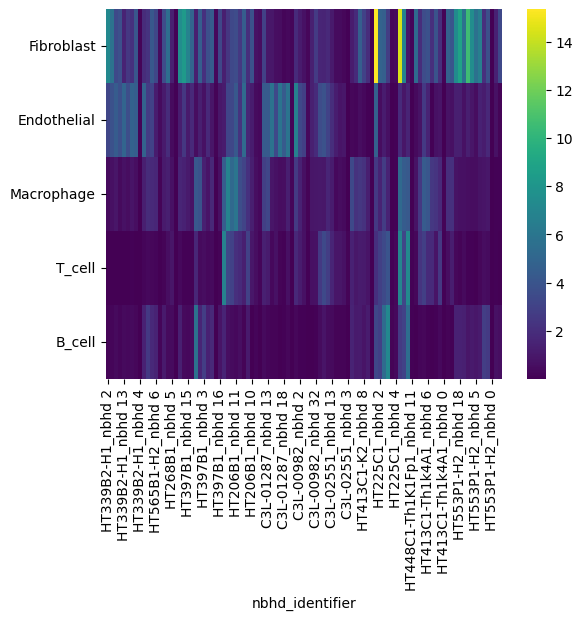

In [386]:
sns.heatmap(agg.loc[id_order, common].T, cmap='viridis')
plt.savefig('/data/estorrs/sandbox/heatmap.svg')

In [248]:
case_to_total_contact = {i:row['contact_frac']
                   for i, row in agg[['case', 'contact_frac']].groupby('case').sum().iterrows()}
case_to_total_contact

{'C3L-00982': 0.9598721590909092,
 'C3L-01287': 0.9598930481283423,
 'C3L-02551': 0.98093058733791,
 'HT206B1': 0.7923706441393875,
 'HT225C1': 0.46363125351320966,
 'HT268B1': 0.3024409605080373,
 'HT339B2-H1': 0.8409387222946545,
 'HT397B1': 0.7138777841233581,
 'HT413C1-K2': 0.9376053962900506,
 'HT413C1-Th1k4A1': 0.7915041179020372,
 'HT448C1-Th1K1Fp1': 0.6756373937677054,
 'HT553P1-H2': 0.8774509803921569,
 'HT565B1-H2': 0.8344827586206897}

In [249]:
tail = agg[['case', 'contact_frac']].groupby('case').sum()
for c in cols:
    if c not in tail.columns:
        tail[c] = np.nan
tail['case'] = tail.index.to_list()
tail['tissue_type'] = [case_to_disease[case] for case in tail['case']]

c2 = alt.Chart(tail).mark_bar().encode(
    alt.X("contact_frac"),
    color=alt.Color('tissue_type').scale(scheme="set2"),
    column=alt.Column('case', sort=case_order)
)

c2

alt.Chart(...)

In [250]:
# for cut in cuts:
cut = cuts[0]

domain = [True, False]
colors = ['seagreen', 'firebrick']

quart_cols = [c for c in agg.columns if str(cut) in c]
idx_cols = ['case', 'renamed_nbhd', 'start', 'stop']
cols = quart_cols + idx_cols

source = agg[cols]
source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
source['start'] += .005
source['stop'] -= .005

c1 = alt.Chart(source).mark_bar().encode(
    x=alt.X("start"),
    x2=alt.X2("stop"),
    y=alt.Y('variable', sort=common),
#     color=alt.Color('renamed_nbhd').scale(scheme="category10"),
    color=alt.Color('value').scale(domain=domain, range=colors),
    column=alt.Column('case', sort=case_order, )
)
c1

alt.Chart(...)

In [251]:
color_map = {
    .75: ['#a882ba', 'white'],
    .90: ['#9c4b8e', 'white'],
    .95: ['#b51029', 'white'],
}
domain = [True, False]
cs = []
for i, cut in enumerate(cuts):
    quart_cols = [c for c in agg.columns if str(cut) == c.split('_q')[-1]]
    idx_cols = ['case', 'renamed_nbhd', 'start', 'stop']
    cols = quart_cols + idx_cols

    source = agg[cols]
    source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
    
    source['start'] += .005
    source['stop'] -= .005

    cs.append(alt.Chart(source).mark_bar(size=18 - (i * 5)).encode(
        x=alt.X("start"),
        x2=alt.X2("stop"),
        y=alt.Y('variable', sort=common),
    #     color=alt.Color('renamed_nbhd').scale(scheme="category10"),
        color=alt.Color('value').scale(domain=domain, range=color_map[cut]),
        column=alt.Column('case', sort=case_order, )
    ).configure_axis(grid=False, domain=False))

In [252]:
cs[0]

alt.Chart(...)

In [253]:
cs[1]

alt.Chart(...)

In [254]:
cs[2]

alt.Chart(...)

In [199]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [325]:
case = 'HT225C1'

In [326]:
case_to_contact_counts[case]

Counter({3: 1701,
         8: 1302,
         6: 1046,
         7: 770,
         0: 696,
         9: 661,
         5: 572,
         1: 546,
         4: 358,
         12: 351,
         11: 331,
         2: 251,
         13: 164,
         10: 116,
         14: 30})

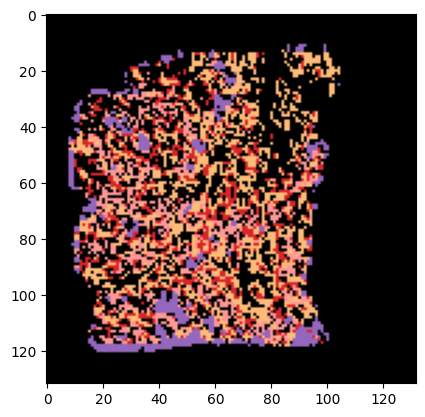

In [327]:
rgb = get_nbhd_rgb(case, [3,8,6,7])
plt.imshow(rgb)

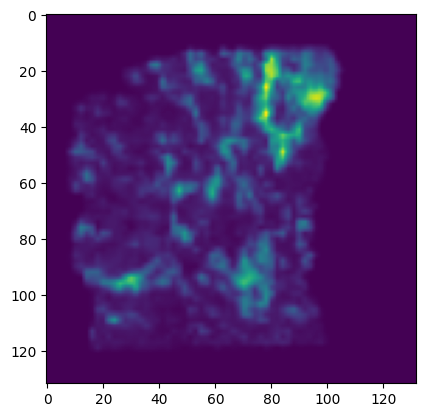

In [329]:
img = get_intensity_img(case, 'visium', 'BGN')
plt.imshow(img)

HT339B2-H1


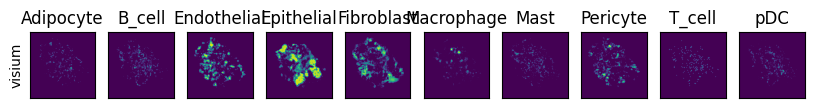

HT565B1-H2


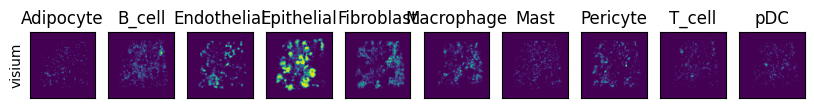

HT268B1


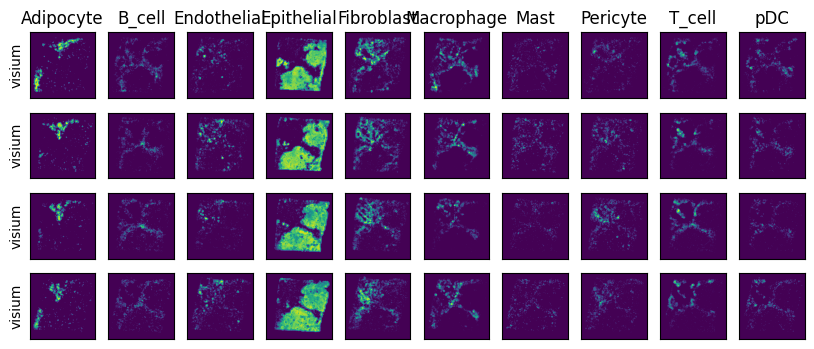

HT397B1


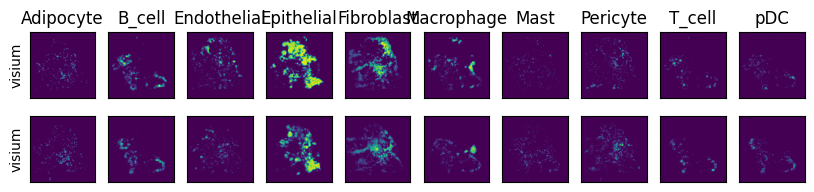

HT206B1


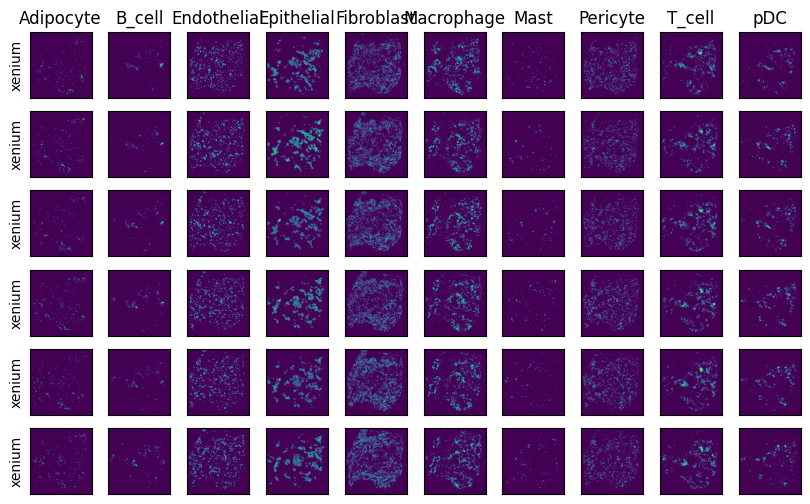

C3L-01287


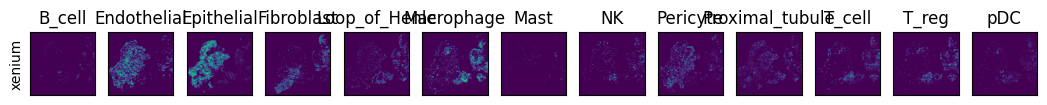

C3L-00982


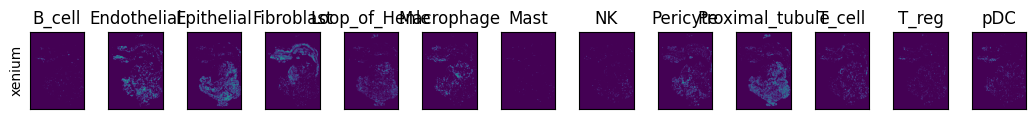

C3L-02551


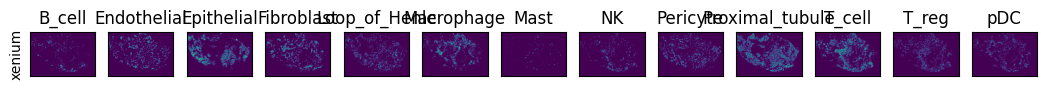

HT413C1-K2


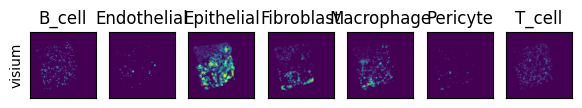

HT225C1


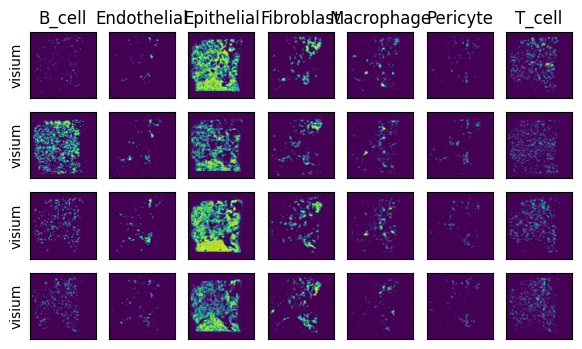

HT448C1-Th1K1Fp1


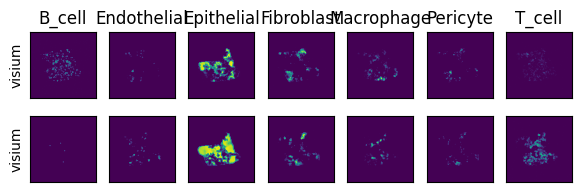

HT413C1-Th1k4A1


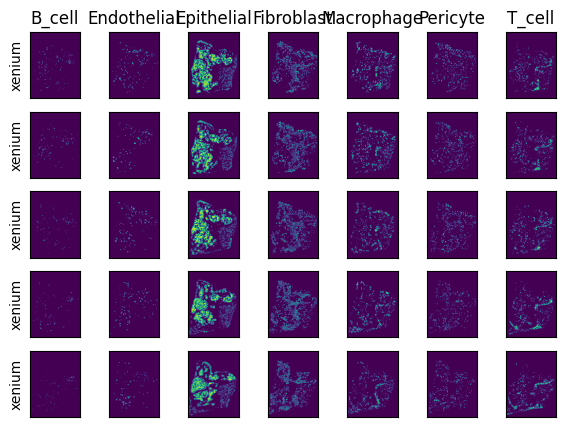

HT553P1-H2


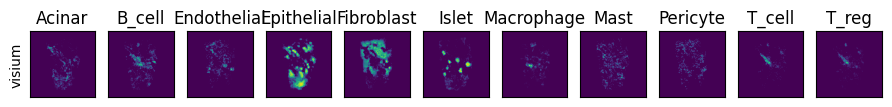

S18-9906


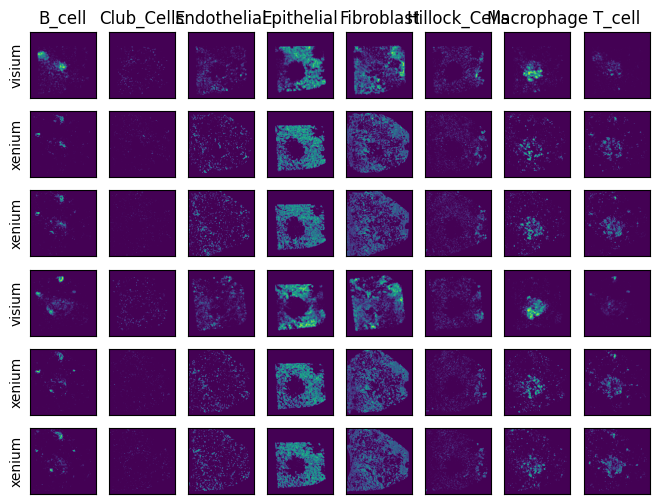

S18-5591-C8


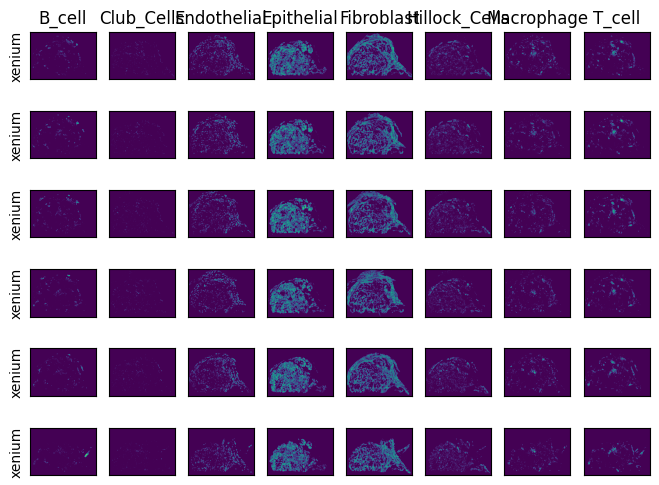

In [84]:
for case in case_order:
    print(case)
    show_cytospace(case)
    plt.show()

In [83]:
tiled = case_to_cytospace['HT206B1']['sid_to_cytospace'][('HT206B1-U1', 'xenium')]
tiled.max((0, 1)), tiled.mean((0, 1))

(array([38, 38, 35, 52, 30, 33, 40, 30, 35, 33]),
 array([0.25415445, 0.19208211, 1.17387586, 2.4480694 , 1.75574291,
        1.52620968, 0.18762219, 1.00904203, 0.97537879, 0.41141251]))

In [84]:
tiled = case_to_cytospace['HT397B1']['sid_to_cytospace'][('HT397B1-U1', 'visium')]
tiled.max((0, 1)), tiled.mean((0, 1))

(array([25, 27, 28, 29, 28, 26,  6, 17, 18, 19]),
 array([0.23467631, 0.59607438, 0.65358127, 3.81123737, 2.02157943,
        0.5828168 , 0.02404729, 0.19857668, 0.12488522, 0.11369376]))

In [176]:
case_to_scored['HT206B1']

Adipocyte    B_cell  Endothelial  Epithelial  Fibroblast  Macrophage  \
0    1.175174  0.027058     0.265718    2.937126    0.765609    0.087135   
1    0.353221  0.729952     0.360073    1.461640    0.500389    0.456441   
2    0.467794  0.011497     0.185402    3.090415    0.273137    0.105494   
3    0.547085  0.047180     0.288857    2.219889    0.735095    0.494149   
4    0.081871  3.067141     0.090025    0.216718    0.071629    0.162054   
5    0.886439  0.045062     0.474151    2.275664    0.882528    0.169683   
6    0.325452  1.090428     0.256218    0.336694    0.327049    0.950438   
7    0.564019  0.083618     0.165282    4.002166    0.090973    0.291605   
8    0.224650  0.302447     0.736943    0.489561    0.840931    1.121945   
9    0.126711  0.391705     0.712808    0.478209    0.613038    1.478892   
10   0.083288  0.036658     0.261785    0.058928    0.961934    0.273008   
11   0.452057  0.232799     0.942222    0.301792    0.877861    1.294211   
12   0.496940  0.397888     0.752194    0.455634    0.667236    1.481278   
13   0.076135  0.013870     0.069993    0.030372    0.129821    0.073050   
14   0.341105  0.406342     0.511840    1.310473    0.633324    0.780741   
15   0.118362  0.134495     0.104508    0.627504    0.178417    0.121196   
16   0.103001  0.101805     1.174806    0.160256    1.129491    0.667746   
17   0.093566  0.002451     0.078127    0.014575    0.441514    0.064344   

        Mast  Pericyte    T_cell       pDC  
0   0.494903  0.895467  0.111413  0.085559  
1   0.356592  0.630618  0.795299  0.810345  
2   0.092092  0.331954  0.023659  0.017345  
3   0.112031  0.711068  0.100938  0.149994  
4   0.520434  0.150927  4.304680  1.479519  
5   0.594173  1.148266  0.046038  0.086647  
6   0.632186  0.410905  1.821303  2.285733  
7   2.611721  0.383543  0.050705  0.005277  
8   0.222467  0.783657  0.812313  0.526792  
9   0.198050  0.753895  0.870434  0.824148  
10  0.051307  0.316972  0.255402  0.061847  
11  0.202870  0.849762  0.557757  0.509109  
12  0.215865  0.810563  0.749557  0.733811  
13  0.011119  0.063925  0.058798  0.010595  
14  0.285325  0.766175  0.494159  0.583954  
15  0.037536  0.205120  0.160120  0.138654  
16  0.196131  0.960577  0.343227  0.210857  
17  0.005813  0.081712  0.059042  0.001224

In [177]:
case_to_scored['HT397B1']

Adipocyte    B_cell  Endothelial  Epithelial  Fibroblast  Macrophage  \
0    0.030097  0.014117     0.062774    0.025266    0.073592    0.009786   
1    0.421562  0.074902     0.423394    2.304755    0.428883    0.135263   
2    0.193294  0.024758     0.208860    2.651437    0.184758    0.038843   
3    0.576484  1.126289     0.336494    0.970072    0.439738    0.506025   
4    0.414936  0.469516     0.350835    2.512483    0.468916    0.209015   
5    0.946785  0.576861     0.869914    1.793418    0.767763    0.315830   
6    0.142907  2.366628     0.260180    0.167930    0.265629    1.600937   
7    0.568770  0.712909     0.450209    0.512789    0.932000    0.665856   
8    0.173956  0.593501     0.087441    0.629873    0.238134    0.128685   
9    0.266709  0.003296     0.874420    1.507558    1.574592    0.082809   
10   0.457645  0.783031     0.304854    2.084700    0.259794    0.347461   
11   0.258754  0.650553     0.573608    0.143127    0.951430    1.498364   
12   0.475415  0.174632     0.782623    0.906877    1.028617    0.297741   
13   0.440477  0.543604     0.584333    0.417133    1.558568    0.602323   
14   0.580851  0.163431     1.164257    1.117113    1.718752    0.537789   
15   0.226993  0.147997     0.455763    0.228408    1.414429    0.391141   
16   0.158635  0.320346     0.453239    0.261684    0.674733    0.229908   
17   0.978505  0.000000     0.000000    0.000000    2.002493    0.000000   
18   0.000000  0.000000     0.000000    0.397140    2.435465    0.193027   
19   0.000000  0.000000     0.780250    0.061098    1.428806    0.000000   

        Mast  Pericyte    T_cell       pDC  
0   0.016102  0.068154  0.009083  0.011086  
1   0.144660  0.353739  0.056165  0.105037  
2   0.092993  0.168545  0.012284  0.000000  
3   0.554397  0.387118  0.598399  0.779385  
4   0.222382  0.424212  0.317107  0.376051  
5   0.300662  0.781399  0.349850  0.288732  
6   0.623658  0.169001  1.869217  1.511185  
7   0.591128  0.624045  0.481653  0.464244  
8   0.161052  0.146701  0.073159  0.512633  
9   0.140669  4.248401  0.000000  0.005922  
10  0.399389  0.306561  0.623847  0.571309  
11  0.674294  0.527528  0.439291  0.626302  
12  0.396662  0.767961  0.125335  0.162934  
13  0.525524  0.741393  0.395869  0.329567  
14  0.553389  1.153495  0.134564  0.222769  
15  0.296723  0.511026  0.127106  0.175150  
16  0.196745  0.435597  0.145907  0.288267  
17  0.000000  1.760417  0.000000  0.000000  
18  0.000000  0.000000  0.000000  0.000000  
19  0.000000  2.200522  0.000000  0.000000

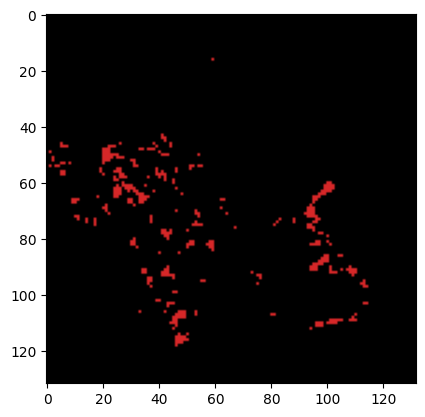

In [179]:
rgb = get_nbhd_rgb('HT397B1', [6])
plt.imshow(rgb)

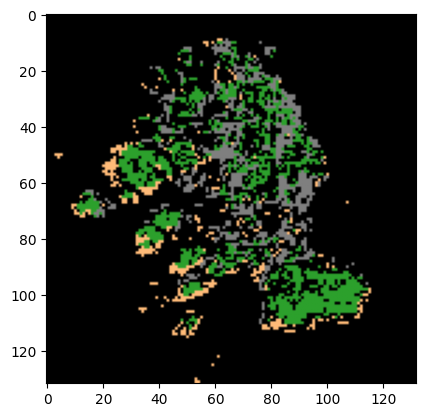

In [183]:
rgb = get_nbhd_rgb('HT397B1', [4,3,14,])
plt.imshow(rgb)

In [180]:
case_to_contact_counts['HT397B1']

Counter({4: 269,
         3: 260,
         14: 216,
         5: 139,
         7: 128,
         15: 126,
         12: 107,
         0: 102,
         10: 102,
         1: 65,
         6: 47,
         16: 43,
         11: 42,
         13: 40,
         9: 31,
         2: 29,
         19: 2,
         8: 2,
         18: 1})

In [329]:
# case = 'S18-5591-C8'
# case = 'S18-9906'
case = 'HT339B2-H1'
# case = 'HT448C1-Th1K1Fp1'
# case = 'HT225C1'
# case = 'HT553P1-H2'

In [330]:
case_to_scored[case]

Endothelial  Epithelial  Fibroblast  Macrophage   NK cell    T cell
0      1.250234    2.794176    1.329241    0.848821  0.226307  0.160094
1      1.054881    1.003202    1.273967    1.073722  0.325184  0.217080
2      0.519493   -0.053913    0.361619    0.397161  0.109750  0.111491
5     -0.017479   -0.324002   -0.265156   -0.288568 -0.074967 -0.075007
6      1.356802    0.998118    1.367709    0.957321  0.114440  0.288783
7      1.382507    0.836168    1.341792    1.103491  0.058357  0.122278
8      1.419700    0.160982    1.062436    0.401001  0.069898  0.302462
9      1.118713    0.429920    0.995155    0.740463  0.183882  0.049972
10     1.027349    0.776899    0.904685    0.524319  0.088540  0.207825
11     1.396897    0.933524    1.412304    1.093386  0.141916  0.228193
12     1.208714    0.362993    1.092045    0.925923  0.128815  0.245858
13     1.533847    1.574924    1.658936    1.157519  0.203362  0.197562
14     0.665576    0.240578    0.549675    0.391725  0.044826  0.039130
15     0.881245    0.457238    1.123703    1.066489 -0.073778  0.073179
16     1.371726   -0.003892    1.217357    0.717979  0.056682  0.340753
17     1.183834    0.444023    0.917750    0.869673  0.076841  0.230978
18     0.802323    0.335618    0.769629    0.800951  0.140228  0.028473

In [331]:
case_to_contact_counts[case]

Counter({0: 267,
         2: 95,
         1: 86,
         11: 80,
         13: 79,
         14: 53,
         4: 42,
         12: 15,
         6: 14,
         7: 12,
         16: 7,
         17: 5,
         8: 4,
         9: 3,
         18: 1})

In [277]:
sum(case_to_contact_counts[case].values())

17196

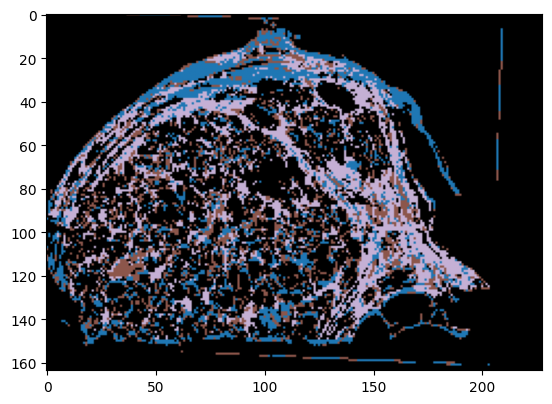

In [310]:
rgb = get_nbhd_rgb(case, [0, 9, 30])
plt.imshow(rgb)
plt.show()

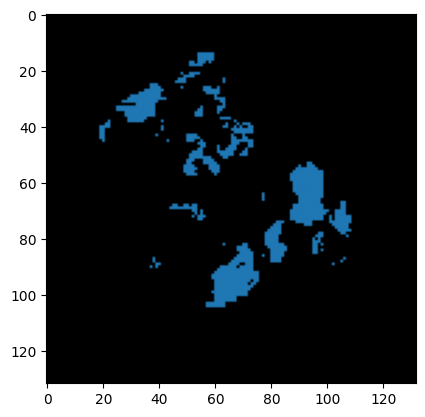

In [332]:
rgb = get_nbhd_rgb(case, [0])
plt.imshow(rgb)
plt.show()

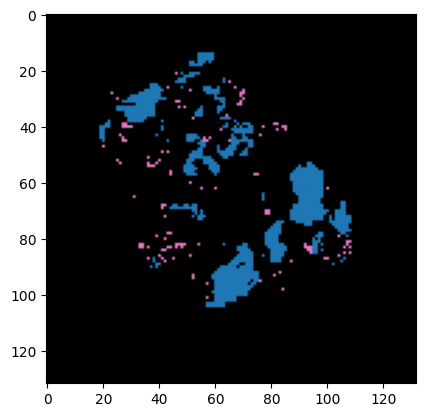

In [333]:
rgb = get_nbhd_rgb(case, [0, 12])
plt.imshow(rgb)
plt.show()

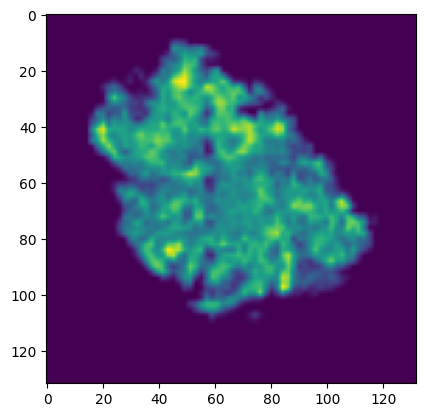

In [334]:
img = get_intensity_img(case, 'visium', 'ACTA2')
plt.imshow(img)
plt.show()

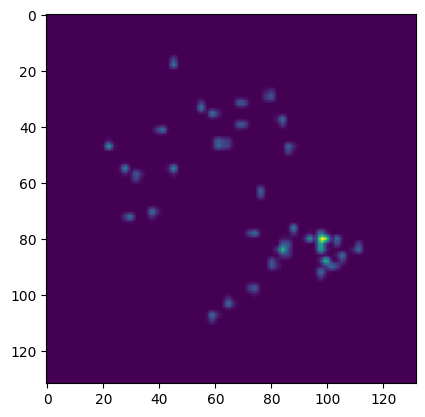

In [335]:
img = get_intensity_img(case, 'visium', 'IL7R')
plt.imshow(img)
plt.show()

In [338]:
components

{'Fibroblast': ['ACTA2', 'COL17A1', 'MYH11', 'CNN1'],
 'T cell': ['CD3D', 'CD3E', 'IL7R', 'CD2', 'CD247'],
 'NK cell': ['GZMK', 'GNLY', 'KLRB1', 'KLRD1', 'NCAM1'],
 'Macrophage': ['CD68', 'CD163'],
 'Epithelial': ['EPCAM'],
 'Endothelial': ['PECAM1']}

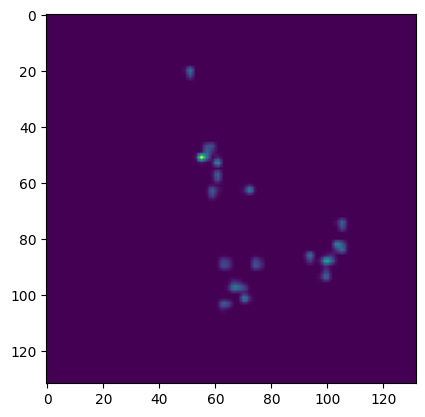

In [342]:
img = get_intensity_img(case, 'visium', 'NCAM1')
plt.imshow(img)
plt.show()

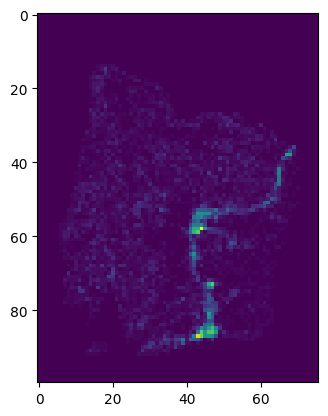

In [111]:
img = get_intensity_img(case, 'xenium', 'IL7R')
plt.imshow(img)
plt.show()

In [ ]:
cols = ['Epithelial', 'Macrophage', 'T cell', 'NK cell', 'Endothelial', 'Fibroblast']
idx = [2, 3,
      6, 12, 9, 11, 4, 5]

In [722]:
# cg = sns.clustermap(case_to_scored['HT339B2-H1'],
#                            standard_scale=0, col_cluster=False)
# plt.show()
# cg
# # plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

In [717]:
case = 'HT206B1'
# # gene_df = case_to_integrated[case]['xenium']
# gene_df = case_to_integrated[case]['visium']
# gs_df = df[df['case']==case]
# gene_df = gene_df[[True if x not in case_to_background[case] else False
#                    for x in gene_df.index]]
# ct_df = score_gene_set(gene_df, components)

# to_macro = {
    
# }




In [647]:
# cg = sns.clustermap(gene_df[[g for g in genes if g in gene_df.columns]],
#                            standard_scale=0, col_cluster=False)
# plt.show()
# cg
# # plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

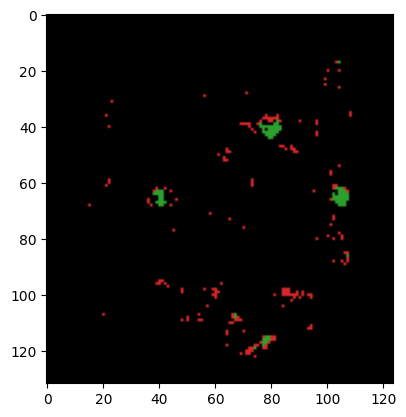

In [724]:
rgb = get_nbhd_rgb(case, [4, 6])
plt.imshow(rgb)
plt.show()

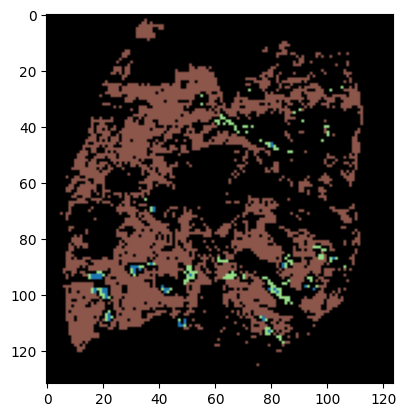

In [504]:
rgb = get_nbhd_rgb(case, [10, 0, 5])
plt.imshow(rgb)
plt.show()